In [1]:
%pylab inline
import pandas as pd
import sys
import gc
import os
import lightgbm as lgb

Populating the interactive namespace from numpy and matplotlib


In [2]:
FOLD=2

In [3]:
print FOLD

2


In [4]:
sys.path.insert(0,"../python/rrvf2017/")

In [5]:
from rrvf_data import   DataGen, normalize
import rrvf_data

In [6]:
def get_index(cols,columns):
    lst=[]
    for c in cols:
        lst.append(np.where(columns==c)[0][0])
    return np.array(lst)

In [7]:
def read_data(offset):
    columns,data=rrvf_data.read_data( offset,"../input/train_test_extb.npy.npz",with_l2=True,with_l3=True)
    rawy=data[:,:,get_index(['visitors'],columns)[0]].copy()
    print len(columns),data.shape,rawy.shape    
    return columns,data,rawy

In [8]:
gc.collect()

0

# cv

In [9]:
n_reg_lookback=7
n_lookforward=1
n_offset=0

In [10]:
lag_cols=array(['visitor_ma28', 'visitor_ma56', 'visitor_ma14', 'visitor_ma112', 'visitor_ma224', 
                'visitor_ma7', 'visitor_sma8', 'visitor_sma4', 'visitor_sma3', 'visitor_sma16', 
                'visitor_sma2', 'visitor_ma4', 'visitor_ma2', 'visitors', 'visitor_lag7', 
                'visitor_lag14', 'visitor_lag28', 'visitor_lag91', 'visitor_lag182', 'geo2_visitors_mean', 
                'station_visitors_mean', 'geo2_count_y1', 'all_count_y1', 'geo1_visitors_mean', 'all_count_y3', 
                'station_count_y3', 'station_count_y4',
               's16_y_nan', 's16_y_std', 's16_y1_ratio', 's16_y2_ratio',
               'bad_ratio'])
len(lag_cols)

32

In [11]:
def make_ondate_train_test(ondate_cols,data,columns):
    ondate_train_test=np.round(data[:,:,get_index(ondate_cols,columns)].copy(),2)
    ondate_train_test=normalize(ondate_train_test)
    v=np.zeros_like(ondate_train_test[:,:,0])
    for i in range(v.shape[0]): v[i]=i
    #ondate_train_test = np.concatenate([np.expand_dims(v,-1),ondate_train_test],axis=-1)
    print ondate_train_test.shape
    return ondate_train_test

In [12]:
ondate_cols =array(['const_one', 'visitor_lag91', 'visitor_lag182', 'TMIN', 'holiday', 'TAVG','f_t',
                    'weekday6', 'weekday5', 'weekday4', 'weekday3', 'weekday2', 'weekday1', 'weekday0',
                    'rv_sum', 'rv_mean', 'rv_gap_mean', 'rv_gap_weighted_mean',
                    '3003nb_conv_fold{}_False_d478.pkl', '3005_rf_fold{}_False_d478.pkl', '3001eb_lgb_fold{}_True_d478.pkl', '3002nb_lstm_fold{}_False_d478.pkl', '3000eb_ridge_fold{}_True_d478.pkl', '3002_lstm_fold{}_False_d478.pkl', '3006_xgb_fold{}_False_d478.pkl', '3003_conv_fold{}_False_d478.pkl', '3000_ridge_fold{}_False_d478.pkl', '3001_lgb_fold{}_False_d478.pkl',
                    'l2_3000_ridge_fold{}_False_d478.pkl', 'l2_3003_conv_fold{}_False_d478.pkl', 'l2_3001_lgb_fold{}_False_d478.pkl', 'l2_3006_xgb_fold{}_False_d478.pkl'                   
                   ])
len(ondate_cols)

32

In [13]:
def make_lag_train_test(lag_cols,data,columns):
    lag_train_test=data[:,:,get_index(lag_cols,columns)].copy()
    #lag_train_test=normalize(lag_train_test)
    print lag_train_test.shape
    return lag_train_test

In [14]:
from sklearn.model_selection import GridSearchCV,ParameterGrid,ParameterSampler
from sklearn.metrics import  make_scorer
from multiprocessing import Pool

# time split

In [15]:
import cPickle as pickle
indexes=rrvf_data.get_train_valid_indexes()

In [16]:
def make_Xy(data_from_gen):
    print data_from_gen[0]['ondatex'].shape,data_from_gen[0]['lagx'].shape,data_from_gen[0]['masky'].shape,data_from_gen[1].shape
    X=np.concatenate([data_from_gen[0]['ondatex'].reshape([data_from_gen[0]['ondatex'].shape[0],-1]),
                    data_from_gen[0]['lagx'].reshape([data_from_gen[0]['lagx'].shape[0],-1])],axis=1)
    y=np.squeeze(data_from_gen[1])
    mask=np.squeeze(data_from_gen[0]['masky'].reshape([data_from_gen[0]['masky'].shape[0],-1]))
    print X.shape,y.shape,mask.shape
    mask= (mask>0) & (y>0)
    X=X[mask]
    y=y[mask]
    dataidx=data_from_gen[3][mask]
    assert X.shape[0]==y.shape[0]
    return X,y,dataidx

In [17]:
from sklearn.metrics import mean_squared_error
def make_model(i, trainX,trainy, validX,validy, colsample_bytree=1,num_leaves=31,subsample=1,
               learning_rate=0.03,max_bin=127,
               min_data_in_leaf=20,lambda_l2=0,
               min_sum_hessian_in_leaf=1e-3, C=0.001,
               objective='binary' ):
        models=[]
        scores=[]
        d_train = lgb.Dataset(trainX, label=trainy,categorical_feature=[0])
        d_valid = lgb.Dataset(validX, label=validy,categorical_feature=[0])
        
        if 1:
            params = {
                'task': 'train',
                'boosting_type': 'gbdt',
                'objective': objective,
                'metric': {'rmse'},
                'num_leaves':num_leaves,
                'learning_rate': learning_rate,
                'feature_fraction': colsample_bytree,
                'bagging_fraction': subsample,
                'min_data_in_leaf': min_data_in_leaf,
                'min_sum_hessian_in_leaf': min_sum_hessian_in_leaf,
                'lambda_l2': lambda_l2,
                'max_bin': max_bin,
                'bagging_freq': 5,
                'nthread': 8,
                'verbose': 0,
                'metric_freq': 50,
                'train_metric': True
            }
            print str(params)
            gbm = lgb.train(params,
                            d_train,
                            num_boost_round=1000,
                            valid_sets=d_valid,
                            early_stopping_rounds=50)

            models.append(gbm)
            validpred=gbm.predict(validX,num_iteration=gbm.best_iteration)
            scores.append(mean_squared_error(validy,validpred))
            print mean_squared_error(trainy,gbm.predict(trainX,num_iteration=gbm.best_iteration)), scores[-1]
        print scores
        print i, "mean score", np.mean(scores)
        return models[0],np.mean(scores),validpred
        #return np.mean(scores) 

In [18]:
def f(iparam,trainX,trainy,validX,validy):
    i,param=iparam
    return make_model(i,trainX,trainy,validX,validy, **param)

In [19]:
import rrvf_data
def g(model,testX,testy,testidx,n_offset):
    test_pred=model.predict(testX,num_iteration=model.best_iteration)    
    df=pd.DataFrame({'y':testy})
    df['pred']=test_pred
    df['dayidx']=testidx[:,1]+n_offset
    df=df.loc[df['y']>0]
    df['error']=df['y']-df['pred']
    df['error2']=df['error']**2
    df['day']=pd.to_datetime(rrvf_data.idx_to_date(df['dayidx'])).map(lambda u: u.weekday+1)
    df2=df.groupby("dayidx").mean() 
    df2['date']=pd.to_datetime(rrvf_data.idx_to_date(df2.index)).map(lambda u: u.date())
    print df2['error2'].mean()
    display(df2)
    return  df2['error2'].mean()

def g2(model,train_gen,offset):
    predlist=[]
    ylist=[]
    daylist=[]
    for i in range(7):
        i=478-7+i-offset
        Xdict,y,dataidx,_=train_gen.get_by_t2(day=i)
        X=np.concatenate([Xdict['ondatex'].reshape([Xdict['ondatex'].shape[0],-1]),
                    Xdict['lagx'].reshape([Xdict['lagx'].shape[0],-1])],axis=1)
        pred=model.predict(X,num_iteration=model.best_iteration).reshape(-1)
        predlist.append(pred)
        daylist.append(np.zeros_like(pred,dtype=int)+i+offset)
        ylist.append(y.reshape(-1))
    ylist=np.concatenate(ylist)
    predlist=np.concatenate(predlist)
    daylist=np.concatenate(daylist)
    df=pd.DataFrame({'y':ylist,'dayidx':daylist,'pred':predlist})
    df=df.loc[df['y']>0]
    df['error']=df['y']-df['pred']
    df['error2']=df['error']**2
    df['day']=pd.to_datetime(rrvf_data.idx_to_date(df['dayidx'])).map(lambda u: u.weekday+1)
    df2=df.groupby("dayidx").mean() 
    df2['date']=pd.to_datetime(rrvf_data.idx_to_date(df2.index)).map(lambda u: u.date())
    print df2['error2'].mean()
    display(df2)
    return  df2['error2'].mean()

PRED_DATE=478
def h(model,train_gen):
    Xdict,_,dataidx,_=train_gen.get_by_t2(day=PRED_DATE)
    X=np.concatenate([Xdict['ondatex'].reshape([Xdict['ondatex'].shape[0],-1]),
                    Xdict['lagx'].reshape([Xdict['lagx'].shape[0],-1])],axis=1)
    #mask=np.squeeze(Xdict['masky'].reshape([Xdict.shape[0],-1]))
    print X.shape
    pred=model.predict(X,num_iteration=model.best_iteration)
    return pred,dataidx


In [20]:
parameter={'colsample_bytree': 0.5,
 'lambda_l2': 1,
 'learning_rate': 0.02,
 'max_bin': 255,
 'min_data_in_leaf': 30,
 'min_sum_hessian_in_leaf': 0.001,
 'num_leaves': 127,
 'objective': 'regression',
 'subsample': 0.8}

In [21]:
EXCLUDE_HARD=False
def _run_once(columns,data,rawy,index, ondate_cols,lag_cols,n_lookforward,n_offset):
    assert n_offset+1==n_lookforward
    batchsize=128
    ondate_train_test=make_ondate_train_test(ondate_cols,data,columns)
    lag_train_test = make_lag_train_test(lag_cols,data,columns)
    train_gen=rrvf_data.DataGen(lag_train_test,ondate_train_test, rawy,n_reg_lookback+1, 478,#478-1*7-39-n_offset, 
                      batchsize=batchsize,valid_split=0.1, indexes=index,lookforward_offset=n_offset,
                      exclude_hard=EXCLUDE_HARD,
                  lookback1=n_reg_lookback,  lookforward=n_lookforward, excluded_days=None)
    valid_gen=None
    test_gen=rrvf_data.DataGen(lag_train_test,ondate_train_test, rawy,478-1*7-n_offset,478, lookforward_offset=n_offset,
                     batchsize=batchsize,lookback1=n_reg_lookback, lookforward=n_lookforward)
    print train_gen.train_steps_per_epoch
    print 0 if valid_gen is None else valid_gen.train_steps_per_epoch
    
    train_data_from_gen=train_gen.get_train()
    trainX,trainy,_=make_Xy(train_data_from_gen)
    valid_data_from_gen=train_gen.get_valid()
    validX,validy,valididx=make_Xy(valid_data_from_gen)
    test_data_from_gen=test_gen.get_train()
    testX,testy,testidx=make_Xy(test_data_from_gen)

    model,score,validpred=f((-1,parameter),trainX,trainy,validX,validy)
    g(model,testX,testy,testidx,n_offset)
    g2(model,train_gen,n_offset)
    
    pred478=h(model,train_gen)
    return score,(validy,valididx,validpred),pred478

def run_once(columns,data,rawy,index, ondate_cols,lag_cols,n_lookforward,n_offset):
    return _run_once(columns,data,rawy,index, ondate_cols,lag_cols,n_lookforward,n_offset)        

In [22]:
def MSE(a,b):
    idx= np.isnan(a) | np.isnan(b)
    a=a[~idx]
    b=b[~idx]
    #print np.mean(~idx)
    return np.mean((a-b)**2)
    return mean_squared_error(a,b)

In [23]:
reload(rrvf_data)

<module 'rrvf_data' from '../python/rrvf2017/rrvf_data.pyc'>

In [24]:
j=FOLD
validpreds={}
for offset in range(1,40):
    print "\n\n",offset
    columns,data,rawy=read_data(offset=offset)
    _,validpred,pred478=run_once(columns,data,rawy, indexes[j],ondate_cols,lag_cols,n_lookforward=offset,n_offset=offset-1)
    validpreds[offset]=[validpred,pred478]
    pickle.dump(validpreds, open('l3_3001_lgb_fold{}_{}_d{}.pkl'.format(j, EXCLUDE_HARD, PRED_DATE),'wb'))



1
(1, 829, 517) (60, 829, 517)
86 (829, 517, 86) (829, 517)
(32,) 0.06769826 14.804288
(829, 517, 32)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (201158, 2) (49582, 2)
train/valid # (201158, 2) (49582, 2)
rand split across time
train has 201158 records out of 389630 records
valid has 49582 records out of 389630 records
train has 5803 records out of 5803 records
no valid set
1571
0
(201158, 1, 32) (201158, 7, 32) (201158, 1) (201158, 1)
(201158, 256) (201158,) (201158,)
(49582, 1, 32) (49582, 7, 32) (49582, 1) (49582, 1)
(49582, 256) (49582,) (49582,)
(5803, 1, 32) (5803, 7, 32) (5803, 1) (5803, 1)
(5803, 256) (5803,) (5803,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.02, 'min_sum_hessian_in_leaf': 0.001, 'b

/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  
/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/lightgbm/basic.py:1030: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/lightgbm/basic.py:642: UserWarning: max_bin keyword has been found in `params` and will be ignored. Please use max_bin argument of the Dataset constructor to pass this parameter.
  'Please use {0} argument of the Dataset constructor to pass this parameter.'.format(key))
/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/lightgbm/basic.py:671: UserWarning: categorical_feature in param dict is overrided.
  warnings.warn('categorical_feature in param dict is overrided.')


[1]	valid_0's rmse: 0.819945
Training until validation scores don't improve for 50 rounds.
[2]	valid_0's rmse: 0.809702
[3]	valid_0's rmse: 0.799675
[4]	valid_0's rmse: 0.789952
[5]	valid_0's rmse: 0.780514
[6]	valid_0's rmse: 0.771306
[7]	valid_0's rmse: 0.762493
[8]	valid_0's rmse: 0.753808
[9]	valid_0's rmse: 0.74538
[10]	valid_0's rmse: 0.737211
[11]	valid_0's rmse: 0.729366
[12]	valid_0's rmse: 0.721789
[13]	valid_0's rmse: 0.714316
[14]	valid_0's rmse: 0.70716
[15]	valid_0's rmse: 0.700063
[16]	valid_0's rmse: 0.693434
[17]	valid_0's rmse: 0.686861
[18]	valid_0's rmse: 0.680531
[19]	valid_0's rmse: 0.674404
[20]	valid_0's rmse: 0.668467
[21]	valid_0's rmse: 0.662578
[22]	valid_0's rmse: 0.656857
[23]	valid_0's rmse: 0.651315
[24]	valid_0's rmse: 0.646096
[25]	valid_0's rmse: 0.640975
[26]	valid_0's rmse: 0.635973
[27]	valid_0's rmse: 0.631107
[28]	valid_0's rmse: 0.626505
[29]	valid_0's rmse: 0.622059
[30]	valid_0's rmse: 0.617741
[31]	valid_0's rmse: 0.613459
[32]	valid_0's rmse

[270]	valid_0's rmse: 0.496873
[271]	valid_0's rmse: 0.496884
[272]	valid_0's rmse: 0.496898
[273]	valid_0's rmse: 0.496915
Early stopping, best iteration is:
[223]	valid_0's rmse: 0.49674
0.22419936757366843 0.24675091142531133
[0.24675091142531133]
-1 mean score 0.24675091142531133
0.200581135565


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.920867  0.008243  0.215089    7  2017-04-16
472     2.507290  2.538756 -0.031465  0.212444    1  2017-04-17
473     2.661330  2.667688 -0.006358  0.233793    2  2017-04-18
474     2.754815  2.749279  0.005536  0.194092    3  2017-04-19
475     2.713762  2.715712 -0.001950  0.223440    4  2017-04-20
476     2.999000  2.988198  0.010801  0.148790    5  2017-04-21
477     3.075529  3.082357 -0.006828  0.176420    6  2017-04-22

0.200581135565


pred         y     error    error2  day        date
dayidx                                                         
471     2.920867  2.929110  0.008243  0.215089    7  2017-04-16
472     2.538756  2.507290 -0.031465  0.212444    1  2017-04-17
473     2.667688  2.661330 -0.006358  0.233793    2  2017-04-18
474     2.749279  2.754815  0.005536  0.194092    3  2017-04-19
475     2.715712  2.713762 -0.001950  0.223440    4  2017-04-20
476     2.988198  2.999000  0.010801  0.148790    5  2017-04-21
477     3.082357  3.075529 -0.006828  0.176420    6  2017-04-22

(829, 256)


2
(1, 829, 517) (60, 829, 517)
86 (829, 517, 86) (829, 517)
(32,) 0.06769826 14.804288
(829, 517, 32)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (200932, 2) (49525, 2)
train/valid # (200932, 2) (49525, 2)
rand split across time
train has 200932 records out of 389630 records
valid has 49525 records out of 389630 records
train has 6632 records out of 6632 records
no valid set
1569
0
(200932, 1, 32) (200932, 7, 32) (200932, 1) (200932, 1)
(200932, 256) (200932,) (200932,)
(49525, 1, 32) (49525, 7, 32) (49525, 1) (49525, 1)
(49525, 256) (49525,) (49525,)
(6632, 1, 32) (6632, 7, 32) (6632, 1) (6632, 1)
(6632, 256) (6632,) (6632,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.02, 'min_sum_hessian_in_leaf'

[234]	valid_0's rmse: 0.50309
[235]	valid_0's rmse: 0.503095
[236]	valid_0's rmse: 0.503095
[237]	valid_0's rmse: 0.503092
[238]	valid_0's rmse: 0.503098
[239]	valid_0's rmse: 0.503102
[240]	valid_0's rmse: 0.503107
[241]	valid_0's rmse: 0.5031
[242]	valid_0's rmse: 0.503095
[243]	valid_0's rmse: 0.503091
[244]	valid_0's rmse: 0.503094
[245]	valid_0's rmse: 0.503093
[246]	valid_0's rmse: 0.503091
[247]	valid_0's rmse: 0.503097
[248]	valid_0's rmse: 0.5031
[249]	valid_0's rmse: 0.503096
[250]	valid_0's rmse: 0.503097
[251]	valid_0's rmse: 0.503101
[252]	valid_0's rmse: 0.503105
[253]	valid_0's rmse: 0.50311
[254]	valid_0's rmse: 0.503103
[255]	valid_0's rmse: 0.503101
[256]	valid_0's rmse: 0.503101
[257]	valid_0's rmse: 0.503089
[258]	valid_0's rmse: 0.50308
[259]	valid_0's rmse: 0.503085
[260]	valid_0's rmse: 0.503082
[261]	valid_0's rmse: 0.50307
[262]	valid_0's rmse: 0.503072
[263]	valid_0's rmse: 0.503069
[264]	valid_0's rmse: 0.503066
[265]	valid_0's rmse: 0.503073
[266]	valid_0's 

y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.911436  0.017674  0.217797    7  2017-04-16
472     2.507290  2.543399 -0.036108  0.210468    1  2017-04-17
473     2.661330  2.664474 -0.003144  0.231499    2  2017-04-18
474     2.754815  2.744815  0.010000  0.196369    3  2017-04-19
475     2.713762  2.722773 -0.009011  0.221931    4  2017-04-20
476     2.999000  2.994104  0.004895  0.150275    5  2017-04-21
477     3.075529  3.074562  0.000967  0.176516    6  2017-04-22

0.200693537031


pred         y     error    error2  day        date
dayidx                                                         
471     2.911436  2.929110  0.017674  0.217797    7  2017-04-16
472     2.543399  2.507290 -0.036108  0.210468    1  2017-04-17
473     2.664474  2.661330 -0.003144  0.231499    2  2017-04-18
474     2.744815  2.754815  0.010000  0.196369    3  2017-04-19
475     2.722773  2.713762 -0.009011  0.221931    4  2017-04-20
476     2.994104  2.999000  0.004895  0.150275    5  2017-04-21
477     3.074562  3.075529  0.000967  0.176516    6  2017-04-22

(829, 256)


3
(1, 829, 517) (60, 829, 517)
86 (829, 517, 86) (829, 517)
(32,) 0.06769826 14.804288
(829, 517, 32)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (200747, 2) (49483, 2)
train/valid # (200747, 2) (49483, 2)
rand split across time
train has 200747 records out of 389630 records
valid has 49483 records out of 389630 records
train has 7461 records out of 7461 records
no valid set
1568
0
(200747, 1, 32) (200747, 7, 32) (200747, 1) (200747, 1)
(200747, 256) (200747,) (200747,)
(49483, 1, 32) (49483, 7, 32) (49483, 1) (49483, 1)
(49483, 256) (49483,) (49483,)
(7461, 1, 32) (7461, 7, 32) (7461, 1) (7461, 1)
(7461, 256) (7461,) (7461,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.02, 'min_sum_hessian_in_leaf'

[235]	valid_0's rmse: 0.504415
[236]	valid_0's rmse: 0.504416
[237]	valid_0's rmse: 0.504406
[238]	valid_0's rmse: 0.504409
[239]	valid_0's rmse: 0.504405
[240]	valid_0's rmse: 0.5044
[241]	valid_0's rmse: 0.504402
[242]	valid_0's rmse: 0.504392
[243]	valid_0's rmse: 0.504389
[244]	valid_0's rmse: 0.504383
[245]	valid_0's rmse: 0.504378
[246]	valid_0's rmse: 0.504377
[247]	valid_0's rmse: 0.504362
[248]	valid_0's rmse: 0.50436
[249]	valid_0's rmse: 0.50436
[250]	valid_0's rmse: 0.504353
[251]	valid_0's rmse: 0.504358
[252]	valid_0's rmse: 0.504355
[253]	valid_0's rmse: 0.504356
[254]	valid_0's rmse: 0.504355
[255]	valid_0's rmse: 0.504348
[256]	valid_0's rmse: 0.504345
[257]	valid_0's rmse: 0.50434
[258]	valid_0's rmse: 0.504334
[259]	valid_0's rmse: 0.504334
[260]	valid_0's rmse: 0.504306
[261]	valid_0's rmse: 0.504297
[262]	valid_0's rmse: 0.504295
[263]	valid_0's rmse: 0.504309
[264]	valid_0's rmse: 0.504311
[265]	valid_0's rmse: 0.50433
[266]	valid_0's rmse: 0.504324
[267]	valid_0'

y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.898934  0.030176  0.220968    7  2017-04-16
472     2.507290  2.536606 -0.029316  0.220574    1  2017-04-17
473     2.661330  2.650412  0.010917  0.242730    2  2017-04-18
474     2.754815  2.755844 -0.001030  0.200434    3  2017-04-19
475     2.713762  2.718856 -0.005095  0.226134    4  2017-04-20
476     2.999000  2.995032  0.003968  0.152296    5  2017-04-21
477     3.075529  3.073100  0.002429  0.180413    6  2017-04-22

0.206221290264


pred         y     error    error2  day        date
dayidx                                                         
471     2.898934  2.929110  0.030176  0.220968    7  2017-04-16
472     2.536606  2.507290 -0.029316  0.220574    1  2017-04-17
473     2.650412  2.661330  0.010917  0.242730    2  2017-04-18
474     2.755844  2.754815 -0.001030  0.200434    3  2017-04-19
475     2.718856  2.713762 -0.005095  0.226134    4  2017-04-20
476     2.995032  2.999000  0.003968  0.152296    5  2017-04-21
477     3.073100  3.075529  0.002429  0.180413    6  2017-04-22

(829, 256)


4
(1, 829, 517) (60, 829, 517)
86 (829, 517, 86) (829, 517)
(32,) 0.06769826 14.804288
(829, 517, 32)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (200584, 2) (49444, 2)
train/valid # (200584, 2) (49444, 2)
rand split across time
train has 200584 records out of 389630 records
valid has 49444 records out of 389630 records
train has 8290 records out of 8290 records
no valid set
1567
0
(200584, 1, 32) (200584, 7, 32) (200584, 1) (200584, 1)
(200584, 256) (200584,) (200584,)
(49444, 1, 32) (49444, 7, 32) (49444, 1) (49444, 1)
(49444, 256) (49444,) (49444,)
(8290, 1, 32) (8290, 7, 32) (8290, 1) (8290, 1)
(8290, 256) (8290,) (8290,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.02, 'min_sum_hessian_in_leaf'

[236]	valid_0's rmse: 0.506597
[237]	valid_0's rmse: 0.506587
[238]	valid_0's rmse: 0.506591
[239]	valid_0's rmse: 0.506588
[240]	valid_0's rmse: 0.506587
[241]	valid_0's rmse: 0.506578
[242]	valid_0's rmse: 0.506574
[243]	valid_0's rmse: 0.506569
[244]	valid_0's rmse: 0.506577
[245]	valid_0's rmse: 0.506593
[246]	valid_0's rmse: 0.506588
[247]	valid_0's rmse: 0.506586
[248]	valid_0's rmse: 0.506582
[249]	valid_0's rmse: 0.506578
[250]	valid_0's rmse: 0.506577
[251]	valid_0's rmse: 0.506575
[252]	valid_0's rmse: 0.506578
[253]	valid_0's rmse: 0.50657
[254]	valid_0's rmse: 0.50657
[255]	valid_0's rmse: 0.506562
[256]	valid_0's rmse: 0.506564
[257]	valid_0's rmse: 0.506563
[258]	valid_0's rmse: 0.506556
[259]	valid_0's rmse: 0.506545
[260]	valid_0's rmse: 0.506542
[261]	valid_0's rmse: 0.506534
[262]	valid_0's rmse: 0.506528
[263]	valid_0's rmse: 0.506525
[264]	valid_0's rmse: 0.506529
[265]	valid_0's rmse: 0.506522
[266]	valid_0's rmse: 0.506531
[267]	valid_0's rmse: 0.506528
[268]	vali

y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.902123  0.026987  0.227132    7  2017-04-16
472     2.507290  2.526516 -0.019225  0.219776    1  2017-04-17
473     2.661330  2.647899  0.013431  0.241735    2  2017-04-18
474     2.754815  2.740018  0.014796  0.203635    3  2017-04-19
475     2.713762  2.721881 -0.008119  0.224940    4  2017-04-20
476     2.999000  2.983071  0.015929  0.154404    5  2017-04-21
477     3.075529  3.069284  0.006245  0.177752    6  2017-04-22

0.207053412236


pred         y     error    error2  day        date
dayidx                                                         
471     2.902123  2.929110  0.026987  0.227132    7  2017-04-16
472     2.526516  2.507290 -0.019225  0.219776    1  2017-04-17
473     2.647899  2.661330  0.013431  0.241735    2  2017-04-18
474     2.740018  2.754815  0.014796  0.203635    3  2017-04-19
475     2.721881  2.713762 -0.008119  0.224940    4  2017-04-20
476     2.983071  2.999000  0.015929  0.154404    5  2017-04-21
477     3.069284  3.075529  0.006245  0.177752    6  2017-04-22

(829, 256)


5
(1, 829, 517) (60, 829, 517)
86 (829, 517, 86) (829, 517)
(32,) 0.06769826 14.804288
(829, 517, 32)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (200384, 2) (49392, 2)
train/valid # (200384, 2) (49392, 2)
rand split across time
train has 200384 records out of 389630 records
valid has 49392 records out of 389630 records
train has 9119 records out of 9119 records
no valid set
1565
0
(200384, 1, 32) (200384, 7, 32) (200384, 1) (200384, 1)
(200384, 256) (200384,) (200384,)
(49392, 1, 32) (49392, 7, 32) (49392, 1) (49392, 1)
(49392, 256) (49392,) (49392,)
(9119, 1, 32) (9119, 7, 32) (9119, 1) (9119, 1)
(9119, 256) (9119,) (9119,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.02, 'min_sum_hessian_in_leaf'

[235]	valid_0's rmse: 0.50834
[236]	valid_0's rmse: 0.50834
[237]	valid_0's rmse: 0.508345
[238]	valid_0's rmse: 0.508342
[239]	valid_0's rmse: 0.508337
[240]	valid_0's rmse: 0.508335
[241]	valid_0's rmse: 0.50834
[242]	valid_0's rmse: 0.508346
[243]	valid_0's rmse: 0.50835
[244]	valid_0's rmse: 0.50834
[245]	valid_0's rmse: 0.50833
[246]	valid_0's rmse: 0.508327
[247]	valid_0's rmse: 0.508331
[248]	valid_0's rmse: 0.508325
[249]	valid_0's rmse: 0.508322
[250]	valid_0's rmse: 0.508323
[251]	valid_0's rmse: 0.508322
[252]	valid_0's rmse: 0.508321
[253]	valid_0's rmse: 0.508317
[254]	valid_0's rmse: 0.508316
[255]	valid_0's rmse: 0.508324
[256]	valid_0's rmse: 0.508328
[257]	valid_0's rmse: 0.508309
[258]	valid_0's rmse: 0.508304
[259]	valid_0's rmse: 0.508301
[260]	valid_0's rmse: 0.50828
[261]	valid_0's rmse: 0.508269
[262]	valid_0's rmse: 0.508267
[263]	valid_0's rmse: 0.508264
[264]	valid_0's rmse: 0.508262
[265]	valid_0's rmse: 0.508251
[266]	valid_0's rmse: 0.508246
[267]	valid_0's

y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.900246  0.028864  0.218412    7  2017-04-16
472     2.507290  2.535601 -0.028311  0.222032    1  2017-04-17
473     2.661330  2.638609  0.022721  0.240704    2  2017-04-18
474     2.754815  2.739450  0.015365  0.200734    3  2017-04-19
475     2.713762  2.715458 -0.001696  0.224142    4  2017-04-20
476     2.999000  2.986829  0.012171  0.151221    5  2017-04-21
477     3.075529  3.076192 -0.000663  0.173842    6  2017-04-22

0.204441203899


pred         y     error    error2  day        date
dayidx                                                         
471     2.900246  2.929110  0.028864  0.218412    7  2017-04-16
472     2.535601  2.507290 -0.028311  0.222032    1  2017-04-17
473     2.638609  2.661330  0.022721  0.240704    2  2017-04-18
474     2.739450  2.754815  0.015365  0.200734    3  2017-04-19
475     2.715458  2.713762 -0.001696  0.224142    4  2017-04-20
476     2.986829  2.999000  0.012171  0.151221    5  2017-04-21
477     3.076192  3.075529 -0.000663  0.173842    6  2017-04-22

(829, 256)


6
(1, 829, 517) (60, 829, 517)
86 (829, 517, 86) (829, 517)
(32,) 0.06769826 15.133374
(829, 517, 32)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (200174, 2) (49339, 2)
train/valid # (200174, 2) (49339, 2)
rand split across time
train has 200174 records out of 389630 records
valid has 49339 records out of 389630 records
train has 9948 records out of 9948 records
no valid set
1563
0
(200174, 1, 32) (200174, 7, 32) (200174, 1) (200174, 1)
(200174, 256) (200174,) (200174,)
(49339, 1, 32) (49339, 7, 32) (49339, 1) (49339, 1)
(49339, 256) (49339,) (49339,)
(9948, 1, 32) (9948, 7, 32) (9948, 1) (9948, 1)
(9948, 256) (9948,) (9948,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.02, 'min_sum_hessian_in_leaf'

[235]	valid_0's rmse: 0.50877
[236]	valid_0's rmse: 0.508769
[237]	valid_0's rmse: 0.508764
[238]	valid_0's rmse: 0.508771
[239]	valid_0's rmse: 0.508773
[240]	valid_0's rmse: 0.508775
[241]	valid_0's rmse: 0.508775
[242]	valid_0's rmse: 0.508773
[243]	valid_0's rmse: 0.508774
[244]	valid_0's rmse: 0.508768
[245]	valid_0's rmse: 0.508767
[246]	valid_0's rmse: 0.508759
[247]	valid_0's rmse: 0.508746
[248]	valid_0's rmse: 0.508743
[249]	valid_0's rmse: 0.508732
[250]	valid_0's rmse: 0.508738
[251]	valid_0's rmse: 0.508738
[252]	valid_0's rmse: 0.508733
[253]	valid_0's rmse: 0.508737
[254]	valid_0's rmse: 0.508731
[255]	valid_0's rmse: 0.508734
[256]	valid_0's rmse: 0.508729
[257]	valid_0's rmse: 0.508712
[258]	valid_0's rmse: 0.508713
[259]	valid_0's rmse: 0.508716
[260]	valid_0's rmse: 0.508711
[261]	valid_0's rmse: 0.508713
[262]	valid_0's rmse: 0.508708
[263]	valid_0's rmse: 0.508713
[264]	valid_0's rmse: 0.50872
[265]	valid_0's rmse: 0.508728
[266]	valid_0's rmse: 0.50873
[267]	valid

y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.910916  0.018194  0.224207    7  2017-04-16
472     2.507290  2.543108 -0.035817  0.229713    1  2017-04-17
473     2.661330  2.643775  0.017555  0.246858    2  2017-04-18
474     2.754815  2.737957  0.016858  0.203438    3  2017-04-19
475     2.713762  2.719997 -0.006236  0.231726    4  2017-04-20
476     2.999000  2.975221  0.023778  0.154387    5  2017-04-21
477     3.075529  3.086183 -0.010653  0.175810    6  2017-04-22

0.209448313139


pred         y     error    error2  day        date
dayidx                                                         
471     2.910916  2.929110  0.018194  0.224207    7  2017-04-16
472     2.543108  2.507290 -0.035817  0.229713    1  2017-04-17
473     2.643775  2.661330  0.017555  0.246858    2  2017-04-18
474     2.737957  2.754815  0.016858  0.203438    3  2017-04-19
475     2.719997  2.713762 -0.006236  0.231726    4  2017-04-20
476     2.975221  2.999000  0.023778  0.154387    5  2017-04-21
477     3.086183  3.075529 -0.010653  0.175810    6  2017-04-22

(829, 256)


7
(1, 829, 517) (60, 829, 517)
86 (829, 517, 86) (829, 517)
(32,) 0.06769826 16.310143
(829, 517, 32)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (199954, 2) (49285, 2)
train/valid # (199954, 2) (49285, 2)
rand split across time
train has 199954 records out of 389630 records
valid has 49285 records out of 389630 records
train has 10777 records out of 10777 records
no valid set
1562
0
(199954, 1, 32) (199954, 7, 32) (199954, 1) (199954, 1)
(199954, 256) (199954,) (199954,)
(49285, 1, 32) (49285, 7, 32) (49285, 1) (49285, 1)
(49285, 256) (49285,) (49285,)
(10777, 1, 32) (10777, 7, 32) (10777, 1) (10777, 1)
(10777, 256) (10777,) (10777,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.02, 'min_sum_hessian

[234]	valid_0's rmse: 0.511291
[235]	valid_0's rmse: 0.511293
[236]	valid_0's rmse: 0.511273
[237]	valid_0's rmse: 0.511285
[238]	valid_0's rmse: 0.5113
[239]	valid_0's rmse: 0.511304
[240]	valid_0's rmse: 0.511294
[241]	valid_0's rmse: 0.511296
[242]	valid_0's rmse: 0.5113
[243]	valid_0's rmse: 0.5113
[244]	valid_0's rmse: 0.511299
[245]	valid_0's rmse: 0.511299
[246]	valid_0's rmse: 0.511287
[247]	valid_0's rmse: 0.511275
[248]	valid_0's rmse: 0.511267
[249]	valid_0's rmse: 0.511253
[250]	valid_0's rmse: 0.511249
[251]	valid_0's rmse: 0.511275
[252]	valid_0's rmse: 0.511274
[253]	valid_0's rmse: 0.511265
[254]	valid_0's rmse: 0.511266
[255]	valid_0's rmse: 0.511267
[256]	valid_0's rmse: 0.511267
[257]	valid_0's rmse: 0.511265
[258]	valid_0's rmse: 0.511272
[259]	valid_0's rmse: 0.511258
[260]	valid_0's rmse: 0.511255
[261]	valid_0's rmse: 0.511249
[262]	valid_0's rmse: 0.511255
[263]	valid_0's rmse: 0.511247
[264]	valid_0's rmse: 0.511254
[265]	valid_0's rmse: 0.511252
[266]	valid_0'

y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.907834  0.021276  0.221943    7  2017-04-16
472     2.507290  2.550821 -0.043530  0.229523    1  2017-04-17
473     2.661330  2.646841  0.014489  0.243994    2  2017-04-18
474     2.754815  2.735429  0.019385  0.201626    3  2017-04-19
475     2.713762  2.712763  0.000999  0.232214    4  2017-04-20
476     2.999000  2.982824  0.016175  0.154036    5  2017-04-21
477     3.075529  3.094880 -0.019351  0.178066    6  2017-04-22

0.208771896508


pred         y     error    error2  day        date
dayidx                                                         
471     2.907834  2.929110  0.021276  0.221943    7  2017-04-16
472     2.550821  2.507290 -0.043530  0.229523    1  2017-04-17
473     2.646841  2.661330  0.014489  0.243994    2  2017-04-18
474     2.735429  2.754815  0.019385  0.201626    3  2017-04-19
475     2.712763  2.713762  0.000999  0.232214    4  2017-04-20
476     2.982824  2.999000  0.016175  0.154036    5  2017-04-21
477     3.094880  3.075529 -0.019351  0.178066    6  2017-04-22

(829, 256)


8
(1, 829, 517) (60, 829, 517)
86 (829, 517, 86) (829, 517)
(32,) 0.06769826 17.574337
(829, 517, 32)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (199722, 2) (49227, 2)
train/valid # (199722, 2) (49227, 2)
rand split across time
train has 199722 records out of 389630 records
valid has 49227 records out of 389630 records
train has 11606 records out of 11606 records
no valid set
1560
0
(199722, 1, 32) (199722, 7, 32) (199722, 1) (199722, 1)
(199722, 256) (199722,) (199722,)
(49227, 1, 32) (49227, 7, 32) (49227, 1) (49227, 1)
(49227, 256) (49227,) (49227,)
(11606, 1, 32) (11606, 7, 32) (11606, 1) (11606, 1)
(11606, 256) (11606,) (11606,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.02, 'min_sum_hessian

[235]	valid_0's rmse: 0.514542
[236]	valid_0's rmse: 0.514539
[237]	valid_0's rmse: 0.514543
[238]	valid_0's rmse: 0.514552
[239]	valid_0's rmse: 0.514548
[240]	valid_0's rmse: 0.514542
[241]	valid_0's rmse: 0.514537
[242]	valid_0's rmse: 0.514528
[243]	valid_0's rmse: 0.51453
[244]	valid_0's rmse: 0.51453
[245]	valid_0's rmse: 0.514525
[246]	valid_0's rmse: 0.514517
[247]	valid_0's rmse: 0.514509
[248]	valid_0's rmse: 0.514493
[249]	valid_0's rmse: 0.514491
[250]	valid_0's rmse: 0.514489
[251]	valid_0's rmse: 0.514485
[252]	valid_0's rmse: 0.514486
[253]	valid_0's rmse: 0.514484
[254]	valid_0's rmse: 0.514488
[255]	valid_0's rmse: 0.514483
[256]	valid_0's rmse: 0.514487
[257]	valid_0's rmse: 0.514484
[258]	valid_0's rmse: 0.514492
[259]	valid_0's rmse: 0.514491
[260]	valid_0's rmse: 0.514491
[261]	valid_0's rmse: 0.514485
[262]	valid_0's rmse: 0.514481
[263]	valid_0's rmse: 0.514472
[264]	valid_0's rmse: 0.514475
[265]	valid_0's rmse: 0.514475
[266]	valid_0's rmse: 0.514483
[267]	vali

y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.927755  0.001354  0.234518    7  2017-04-16
472     2.507290  2.549290 -0.041999  0.227682    1  2017-04-17
473     2.661330  2.652490  0.008840  0.252992    2  2017-04-18
474     2.754815  2.742155  0.012660  0.213880    3  2017-04-19
475     2.713762  2.718792 -0.005030  0.237420    4  2017-04-20
476     2.999000  2.971802  0.027197  0.161753    5  2017-04-21
477     3.075529  3.090417 -0.014887  0.179876    6  2017-04-22

0.215445910056


pred         y     error    error2  day        date
dayidx                                                         
471     2.927755  2.929110  0.001354  0.234518    7  2017-04-16
472     2.549290  2.507290 -0.041999  0.227682    1  2017-04-17
473     2.652490  2.661330  0.008840  0.252992    2  2017-04-18
474     2.742155  2.754815  0.012660  0.213880    3  2017-04-19
475     2.718792  2.713762 -0.005030  0.237420    4  2017-04-20
476     2.971802  2.999000  0.027197  0.161753    5  2017-04-21
477     3.090417  3.075529 -0.014887  0.179876    6  2017-04-22

(829, 256)


9
(1, 829, 517) (60, 829, 517)
86 (829, 517, 86) (829, 517)
(32,) 0.06769826 18.806503
(829, 517, 32)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (199495, 2) (49172, 2)
train/valid # (199495, 2) (49172, 2)
rand split across time
train has 199495 records out of 389630 records
valid has 49172 records out of 389630 records
train has 12435 records out of 12435 records
no valid set
1558
0
(199495, 1, 32) (199495, 7, 32) (199495, 1) (199495, 1)
(199495, 256) (199495,) (199495,)
(49172, 1, 32) (49172, 7, 32) (49172, 1) (49172, 1)
(49172, 256) (49172,) (49172,)
(12435, 1, 32) (12435, 7, 32) (12435, 1) (12435, 1)
(12435, 256) (12435,) (12435,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.02, 'min_sum_hessian

[236]	valid_0's rmse: 0.51714
[237]	valid_0's rmse: 0.51714
[238]	valid_0's rmse: 0.51716
[239]	valid_0's rmse: 0.517156
[240]	valid_0's rmse: 0.517153
[241]	valid_0's rmse: 0.517158
[242]	valid_0's rmse: 0.517147
[243]	valid_0's rmse: 0.51714
[244]	valid_0's rmse: 0.51713
[245]	valid_0's rmse: 0.517145
[246]	valid_0's rmse: 0.51714
[247]	valid_0's rmse: 0.517144
[248]	valid_0's rmse: 0.517122
[249]	valid_0's rmse: 0.517113
[250]	valid_0's rmse: 0.517113
[251]	valid_0's rmse: 0.517107
[252]	valid_0's rmse: 0.517106
[253]	valid_0's rmse: 0.517112
[254]	valid_0's rmse: 0.517119
[255]	valid_0's rmse: 0.517122
[256]	valid_0's rmse: 0.517117
[257]	valid_0's rmse: 0.517115
[258]	valid_0's rmse: 0.517114
[259]	valid_0's rmse: 0.517107
[260]	valid_0's rmse: 0.517085
[261]	valid_0's rmse: 0.517104
[262]	valid_0's rmse: 0.517104
[263]	valid_0's rmse: 0.517096
[264]	valid_0's rmse: 0.517087
[265]	valid_0's rmse: 0.517085
[266]	valid_0's rmse: 0.517092
[267]	valid_0's rmse: 0.517106
[268]	valid_0'

y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.914300  0.014810  0.237190    7  2017-04-16
472     2.507290  2.553447 -0.046156  0.224683    1  2017-04-17
473     2.661330  2.665122 -0.003792  0.251216    2  2017-04-18
474     2.754815  2.734685  0.020129  0.212981    3  2017-04-19
475     2.713762  2.722068 -0.008306  0.232327    4  2017-04-20
476     2.999000  2.970664  0.028335  0.159778    5  2017-04-21
477     3.075529  3.083777 -0.008248  0.182877    6  2017-04-22

0.214435927343


pred         y     error    error2  day        date
dayidx                                                         
471     2.914300  2.929110  0.014810  0.237190    7  2017-04-16
472     2.553447  2.507290 -0.046156  0.224683    1  2017-04-17
473     2.665122  2.661330 -0.003792  0.251216    2  2017-04-18
474     2.734685  2.754815  0.020129  0.212981    3  2017-04-19
475     2.722068  2.713762 -0.008306  0.232327    4  2017-04-20
476     2.970664  2.999000  0.028335  0.159778    5  2017-04-21
477     3.083777  3.075529 -0.008248  0.182877    6  2017-04-22

(829, 256)


10
(1, 829, 517) (60, 829, 517)
86 (829, 517, 86) (829, 517)
(32,) 0.06769826 19.926521
(829, 517, 32)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (199316, 2) (49135, 2)
train/valid # (199316, 2) (49135, 2)
rand split across time
train has 199316 records out of 389630 records
valid has 49135 records out of 389630 records
train has 13264 records out of 13264 records
no valid set
1557
0
(199316, 1, 32) (199316, 7, 32) (199316, 1) (199316, 1)
(199316, 256) (199316,) (199316,)
(49135, 1, 32) (49135, 7, 32) (49135, 1) (49135, 1)
(49135, 256) (49135,) (49135,)
(13264, 1, 32) (13264, 7, 32) (13264, 1) (13264, 1)
(13264, 256) (13264,) (13264,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.02, 'min_sum_hessia

[234]	valid_0's rmse: 0.517758
[235]	valid_0's rmse: 0.517755
[236]	valid_0's rmse: 0.517757
[237]	valid_0's rmse: 0.517751
[238]	valid_0's rmse: 0.517746
[239]	valid_0's rmse: 0.517751
[240]	valid_0's rmse: 0.517732
[241]	valid_0's rmse: 0.517735
[242]	valid_0's rmse: 0.517733
[243]	valid_0's rmse: 0.517721
[244]	valid_0's rmse: 0.517716
[245]	valid_0's rmse: 0.517708
[246]	valid_0's rmse: 0.517715
[247]	valid_0's rmse: 0.517692
[248]	valid_0's rmse: 0.517677
[249]	valid_0's rmse: 0.517682
[250]	valid_0's rmse: 0.517687
[251]	valid_0's rmse: 0.517695
[252]	valid_0's rmse: 0.517701
[253]	valid_0's rmse: 0.517704
[254]	valid_0's rmse: 0.517735
[255]	valid_0's rmse: 0.517744
[256]	valid_0's rmse: 0.517735
[257]	valid_0's rmse: 0.517728
[258]	valid_0's rmse: 0.517713
[259]	valid_0's rmse: 0.517712
[260]	valid_0's rmse: 0.517721
[261]	valid_0's rmse: 0.51772
[262]	valid_0's rmse: 0.517725
[263]	valid_0's rmse: 0.517719
[264]	valid_0's rmse: 0.517708
[265]	valid_0's rmse: 0.517708
[266]	val

y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.911858  0.017252  0.237017    7  2017-04-16
472     2.507290  2.546101 -0.038811  0.231739    1  2017-04-17
473     2.661330  2.664292 -0.002963  0.256753    2  2017-04-18
474     2.754815  2.745093  0.009722  0.214216    3  2017-04-19
475     2.713762  2.724157 -0.010396  0.234193    4  2017-04-20
476     2.999000  2.972019  0.026981  0.160623    5  2017-04-21
477     3.075529  3.085485 -0.009956  0.187221    6  2017-04-22

0.217394604207


pred         y     error    error2  day        date
dayidx                                                         
471     2.911858  2.929110  0.017252  0.237017    7  2017-04-16
472     2.546101  2.507290 -0.038811  0.231739    1  2017-04-17
473     2.664292  2.661330 -0.002963  0.256753    2  2017-04-18
474     2.745093  2.754815  0.009722  0.214216    3  2017-04-19
475     2.724157  2.713762 -0.010396  0.234193    4  2017-04-20
476     2.972019  2.999000  0.026981  0.160623    5  2017-04-21
477     3.085485  3.075529 -0.009956  0.187221    6  2017-04-22

(829, 256)


11
(1, 829, 517) (60, 829, 517)
86 (829, 517, 86) (829, 517)
(32,) 0.06769826 21.05768
(829, 517, 32)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (199138, 2) (49087, 2)
train/valid # (199138, 2) (49087, 2)
rand split across time
train has 199138 records out of 389630 records
valid has 49087 records out of 389630 records
train has 14093 records out of 14093 records
no valid set
1555
0
(199138, 1, 32) (199138, 7, 32) (199138, 1) (199138, 1)
(199138, 256) (199138,) (199138,)
(49087, 1, 32) (49087, 7, 32) (49087, 1) (49087, 1)
(49087, 256) (49087,) (49087,)
(14093, 1, 32) (14093, 7, 32) (14093, 1) (14093, 1)
(14093, 256) (14093,) (14093,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.02, 'min_sum_hessian

[236]	valid_0's rmse: 0.51776
[237]	valid_0's rmse: 0.517747
[238]	valid_0's rmse: 0.517737
[239]	valid_0's rmse: 0.517737
[240]	valid_0's rmse: 0.517726
[241]	valid_0's rmse: 0.517723
[242]	valid_0's rmse: 0.517718
[243]	valid_0's rmse: 0.517737
[244]	valid_0's rmse: 0.517758
[245]	valid_0's rmse: 0.517764
[246]	valid_0's rmse: 0.517772
[247]	valid_0's rmse: 0.517775
[248]	valid_0's rmse: 0.517774
[249]	valid_0's rmse: 0.517785
[250]	valid_0's rmse: 0.517777
[251]	valid_0's rmse: 0.51777
[252]	valid_0's rmse: 0.517775
[253]	valid_0's rmse: 0.517779
[254]	valid_0's rmse: 0.517764
[255]	valid_0's rmse: 0.51776
[256]	valid_0's rmse: 0.517776
[257]	valid_0's rmse: 0.517765
[258]	valid_0's rmse: 0.517764
[259]	valid_0's rmse: 0.517763
[260]	valid_0's rmse: 0.517767
[261]	valid_0's rmse: 0.517764
[262]	valid_0's rmse: 0.517768
[263]	valid_0's rmse: 0.517769
[264]	valid_0's rmse: 0.517779
[265]	valid_0's rmse: 0.517765
[266]	valid_0's rmse: 0.517764
[267]	valid_0's rmse: 0.517773
[268]	valid

y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.898903  0.030207  0.235400    7  2017-04-16
472     2.507290  2.552921 -0.045631  0.234498    1  2017-04-17
473     2.661330  2.664031 -0.002701  0.260711    2  2017-04-18
474     2.754815  2.733049  0.021765  0.213024    3  2017-04-19
475     2.713762  2.733089 -0.019327  0.233847    4  2017-04-20
476     2.999000  2.977549  0.021450  0.163001    5  2017-04-21
477     3.075529  3.069277  0.006252  0.184313    6  2017-04-22

0.217827764525


pred         y     error    error2  day        date
dayidx                                                         
471     2.898903  2.929110  0.030207  0.235400    7  2017-04-16
472     2.552921  2.507290 -0.045631  0.234498    1  2017-04-17
473     2.664031  2.661330 -0.002701  0.260711    2  2017-04-18
474     2.733049  2.754815  0.021765  0.213024    3  2017-04-19
475     2.733089  2.713762 -0.019327  0.233847    4  2017-04-20
476     2.977549  2.999000  0.021450  0.163001    5  2017-04-21
477     3.069277  3.075529  0.006252  0.184313    6  2017-04-22

(829, 256)


12
(1, 829, 517) (60, 829, 517)
86 (829, 517, 86) (829, 517)
(32,) 0.06769826 22.115147
(829, 517, 32)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (198922, 2) (49036, 2)
train/valid # (198922, 2) (49036, 2)
rand split across time
train has 198922 records out of 389630 records
valid has 49036 records out of 389630 records
train has 14922 records out of 14922 records
no valid set
1554
0
(198922, 1, 32) (198922, 7, 32) (198922, 1) (198922, 1)
(198922, 256) (198922,) (198922,)
(49036, 1, 32) (49036, 7, 32) (49036, 1) (49036, 1)
(49036, 256) (49036,) (49036,)
(14922, 1, 32) (14922, 7, 32) (14922, 1) (14922, 1)
(14922, 256) (14922,) (14922,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.02, 'min_sum_hessia

[236]	valid_0's rmse: 0.519397
[237]	valid_0's rmse: 0.519399
[238]	valid_0's rmse: 0.519401
[239]	valid_0's rmse: 0.519398
[240]	valid_0's rmse: 0.519397
[241]	valid_0's rmse: 0.519396
[242]	valid_0's rmse: 0.51939
[243]	valid_0's rmse: 0.51939
[244]	valid_0's rmse: 0.51939
[245]	valid_0's rmse: 0.519376
[246]	valid_0's rmse: 0.51937
[247]	valid_0's rmse: 0.519367
[248]	valid_0's rmse: 0.519374
[249]	valid_0's rmse: 0.519365
[250]	valid_0's rmse: 0.519367
[251]	valid_0's rmse: 0.519371
[252]	valid_0's rmse: 0.519366
[253]	valid_0's rmse: 0.519361
[254]	valid_0's rmse: 0.519353
[255]	valid_0's rmse: 0.519338
[256]	valid_0's rmse: 0.519325
[257]	valid_0's rmse: 0.51933
[258]	valid_0's rmse: 0.519312
[259]	valid_0's rmse: 0.519311
[260]	valid_0's rmse: 0.519317
[261]	valid_0's rmse: 0.519309
[262]	valid_0's rmse: 0.51931
[263]	valid_0's rmse: 0.519321
[264]	valid_0's rmse: 0.519326
[265]	valid_0's rmse: 0.51933
[266]	valid_0's rmse: 0.519321
[267]	valid_0's rmse: 0.519323
[268]	valid_0's

y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.896369  0.032741  0.236994    7  2017-04-16
472     2.507290  2.550413 -0.043123  0.229354    1  2017-04-17
473     2.661330  2.665503 -0.004173  0.257689    2  2017-04-18
474     2.754815  2.729971  0.024843  0.214265    3  2017-04-19
475     2.713762  2.728531 -0.014769  0.227871    4  2017-04-20
476     2.999000  2.972329  0.026671  0.160828    5  2017-04-21
477     3.075529  3.074412  0.001117  0.183060    6  2017-04-22

0.215722903085


pred         y     error    error2  day        date
dayidx                                                         
471     2.896369  2.929110  0.032741  0.236994    7  2017-04-16
472     2.550413  2.507290 -0.043123  0.229354    1  2017-04-17
473     2.665503  2.661330 -0.004173  0.257689    2  2017-04-18
474     2.729971  2.754815  0.024843  0.214265    3  2017-04-19
475     2.728531  2.713762 -0.014769  0.227871    4  2017-04-20
476     2.972329  2.999000  0.026671  0.160828    5  2017-04-21
477     3.074412  3.075529  0.001117  0.183060    6  2017-04-22

(829, 256)


13
(1, 829, 517) (60, 829, 517)
86 (829, 517, 86) (829, 517)
(32,) 0.06769826 23.15517
(829, 517, 32)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (198710, 2) (48985, 2)
train/valid # (198710, 2) (48985, 2)
rand split across time
train has 198710 records out of 389630 records
valid has 48985 records out of 389630 records
train has 15751 records out of 15751 records
no valid set
1552
0
(198710, 1, 32) (198710, 7, 32) (198710, 1) (198710, 1)
(198710, 256) (198710,) (198710,)
(48985, 1, 32) (48985, 7, 32) (48985, 1) (48985, 1)
(48985, 256) (48985,) (48985,)
(15751, 1, 32) (15751, 7, 32) (15751, 1) (15751, 1)
(15751, 256) (15751,) (15751,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.02, 'min_sum_hessian

[235]	valid_0's rmse: 0.520087
[236]	valid_0's rmse: 0.520085
[237]	valid_0's rmse: 0.520082
[238]	valid_0's rmse: 0.520078
[239]	valid_0's rmse: 0.520068
[240]	valid_0's rmse: 0.520063
[241]	valid_0's rmse: 0.520077
[242]	valid_0's rmse: 0.520074
[243]	valid_0's rmse: 0.520077
[244]	valid_0's rmse: 0.520085
[245]	valid_0's rmse: 0.520092
[246]	valid_0's rmse: 0.520101
[247]	valid_0's rmse: 0.5201
[248]	valid_0's rmse: 0.520109
[249]	valid_0's rmse: 0.52012
[250]	valid_0's rmse: 0.520128
[251]	valid_0's rmse: 0.520125
[252]	valid_0's rmse: 0.520134
[253]	valid_0's rmse: 0.520135
[254]	valid_0's rmse: 0.520128
[255]	valid_0's rmse: 0.520131
[256]	valid_0's rmse: 0.52013
[257]	valid_0's rmse: 0.520142
[258]	valid_0's rmse: 0.520146
[259]	valid_0's rmse: 0.52015
[260]	valid_0's rmse: 0.520144
[261]	valid_0's rmse: 0.52015
[262]	valid_0's rmse: 0.520151
[263]	valid_0's rmse: 0.520153
[264]	valid_0's rmse: 0.520151
[265]	valid_0's rmse: 0.520155
[266]	valid_0's rmse: 0.520164
[267]	valid_0'

y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.899411  0.029699  0.242310    7  2017-04-16
472     2.507290  2.550741 -0.043451  0.235595    1  2017-04-17
473     2.661330  2.670828 -0.009499  0.261147    2  2017-04-18
474     2.754815  2.738135  0.016680  0.220001    3  2017-04-19
475     2.713762  2.729832 -0.016071  0.237755    4  2017-04-20
476     2.999000  2.979871  0.019129  0.165181    5  2017-04-21
477     3.075529  3.066798  0.008731  0.179961    6  2017-04-22

0.220278593978


pred         y     error    error2  day        date
dayidx                                                         
471     2.899411  2.929110  0.029699  0.242310    7  2017-04-16
472     2.550741  2.507290 -0.043451  0.235595    1  2017-04-17
473     2.670828  2.661330 -0.009499  0.261147    2  2017-04-18
474     2.738135  2.754815  0.016680  0.220001    3  2017-04-19
475     2.729832  2.713762 -0.016071  0.237755    4  2017-04-20
476     2.979871  2.999000  0.019129  0.165181    5  2017-04-21
477     3.066798  3.075529  0.008731  0.179961    6  2017-04-22

(829, 256)


14
(1, 829, 517) (60, 829, 517)
86 (829, 517, 86) (829, 517)
(32,) 0.06769826 24.22639
(829, 517, 32)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (198486, 2) (48931, 2)
train/valid # (198486, 2) (48931, 2)
rand split across time
train has 198486 records out of 389630 records
valid has 48931 records out of 389630 records
train has 16580 records out of 16580 records
no valid set
1550
0
(198486, 1, 32) (198486, 7, 32) (198486, 1) (198486, 1)
(198486, 256) (198486,) (198486,)
(48931, 1, 32) (48931, 7, 32) (48931, 1) (48931, 1)
(48931, 256) (48931,) (48931,)
(16580, 1, 32) (16580, 7, 32) (16580, 1) (16580, 1)
(16580, 256) (16580,) (16580,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.02, 'min_sum_hessian

[236]	valid_0's rmse: 0.520798
[237]	valid_0's rmse: 0.520789
[238]	valid_0's rmse: 0.520793
[239]	valid_0's rmse: 0.520801
[240]	valid_0's rmse: 0.520808
[241]	valid_0's rmse: 0.520811
[242]	valid_0's rmse: 0.520816
[243]	valid_0's rmse: 0.520823
[244]	valid_0's rmse: 0.520824
[245]	valid_0's rmse: 0.520815
[246]	valid_0's rmse: 0.520816
[247]	valid_0's rmse: 0.520818
[248]	valid_0's rmse: 0.520824
[249]	valid_0's rmse: 0.520825
[250]	valid_0's rmse: 0.520832
[251]	valid_0's rmse: 0.520836
[252]	valid_0's rmse: 0.520833
[253]	valid_0's rmse: 0.520834
[254]	valid_0's rmse: 0.520834
[255]	valid_0's rmse: 0.520835
[256]	valid_0's rmse: 0.520809
[257]	valid_0's rmse: 0.520817
[258]	valid_0's rmse: 0.520826
[259]	valid_0's rmse: 0.520828
[260]	valid_0's rmse: 0.52084
[261]	valid_0's rmse: 0.520841
[262]	valid_0's rmse: 0.52083
[263]	valid_0's rmse: 0.520832
[264]	valid_0's rmse: 0.520819
[265]	valid_0's rmse: 0.520821
[266]	valid_0's rmse: 0.52083
[267]	valid_0's rmse: 0.520833
[268]	valid

y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.891517  0.037593  0.241900    7  2017-04-16
472     2.507290  2.546722 -0.039431  0.234125    1  2017-04-17
473     2.661330  2.664264 -0.002934  0.260115    2  2017-04-18
474     2.754815  2.731149  0.023665  0.220443    3  2017-04-19
475     2.713762  2.730378 -0.016617  0.235994    4  2017-04-20
476     2.999000  2.988503  0.010496  0.161175    5  2017-04-21
477     3.075529  3.078543 -0.003014  0.182546    6  2017-04-22

0.219471222769


pred         y     error    error2  day        date
dayidx                                                         
471     2.891517  2.929110  0.037593  0.241900    7  2017-04-16
472     2.546722  2.507290 -0.039431  0.234125    1  2017-04-17
473     2.664264  2.661330 -0.002934  0.260115    2  2017-04-18
474     2.731149  2.754815  0.023665  0.220443    3  2017-04-19
475     2.730378  2.713762 -0.016617  0.235994    4  2017-04-20
476     2.988503  2.999000  0.010496  0.161175    5  2017-04-21
477     3.078543  3.075529 -0.003014  0.182546    6  2017-04-22

(829, 256)


15
(1, 829, 517) (60, 829, 517)
86 (829, 517, 86) (829, 517)
(32,) 0.06769826 25.357664
(829, 517, 32)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (198254, 2) (48873, 2)
train/valid # (198254, 2) (48873, 2)
rand split across time
train has 198254 records out of 389630 records
valid has 48873 records out of 389630 records
train has 17409 records out of 17409 records
no valid set
1548
0
(198254, 1, 32) (198254, 7, 32) (198254, 1) (198254, 1)
(198254, 256) (198254,) (198254,)
(48873, 1, 32) (48873, 7, 32) (48873, 1) (48873, 1)
(48873, 256) (48873,) (48873,)
(17409, 1, 32) (17409, 7, 32) (17409, 1) (17409, 1)
(17409, 256) (17409,) (17409,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.02, 'min_sum_hessia

[235]	valid_0's rmse: 0.524417
[236]	valid_0's rmse: 0.524403
[237]	valid_0's rmse: 0.524409
[238]	valid_0's rmse: 0.524414
[239]	valid_0's rmse: 0.524409
[240]	valid_0's rmse: 0.524413
[241]	valid_0's rmse: 0.524412
[242]	valid_0's rmse: 0.524396
[243]	valid_0's rmse: 0.524412
[244]	valid_0's rmse: 0.5244
[245]	valid_0's rmse: 0.524399
[246]	valid_0's rmse: 0.524402
[247]	valid_0's rmse: 0.5244
[248]	valid_0's rmse: 0.524421
[249]	valid_0's rmse: 0.524436
[250]	valid_0's rmse: 0.524435
[251]	valid_0's rmse: 0.524436
[252]	valid_0's rmse: 0.524434
[253]	valid_0's rmse: 0.524437
[254]	valid_0's rmse: 0.524434
[255]	valid_0's rmse: 0.524432
[256]	valid_0's rmse: 0.52442
[257]	valid_0's rmse: 0.524412
[258]	valid_0's rmse: 0.524406
[259]	valid_0's rmse: 0.524406
[260]	valid_0's rmse: 0.524392
[261]	valid_0's rmse: 0.524389
[262]	valid_0's rmse: 0.524375
[263]	valid_0's rmse: 0.524369
[264]	valid_0's rmse: 0.524371
[265]	valid_0's rmse: 0.52437
[266]	valid_0's rmse: 0.524358
[267]	valid_0'

y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.912549  0.016561  0.247282    7  2017-04-16
472     2.507290  2.545201 -0.037910  0.233982    1  2017-04-17
473     2.661330  2.658501  0.002829  0.263762    2  2017-04-18
474     2.754815  2.728276  0.026538  0.217071    3  2017-04-19
475     2.713762  2.730464 -0.016703  0.236364    4  2017-04-20
476     2.999000  2.991183  0.007817  0.164027    5  2017-04-21
477     3.075529  3.074133  0.001396  0.184187    6  2017-04-22

0.220953657083


pred         y     error    error2  day        date
dayidx                                                         
471     2.912549  2.929110  0.016561  0.247282    7  2017-04-16
472     2.545201  2.507290 -0.037910  0.233982    1  2017-04-17
473     2.658501  2.661330  0.002829  0.263762    2  2017-04-18
474     2.728276  2.754815  0.026538  0.217071    3  2017-04-19
475     2.730464  2.713762 -0.016703  0.236364    4  2017-04-20
476     2.991183  2.999000  0.007817  0.164027    5  2017-04-21
477     3.074133  3.075529  0.001396  0.184187    6  2017-04-22

(829, 256)


16
(1, 829, 517) (60, 829, 517)
86 (829, 517, 86) (829, 517)
(32,) 0.06769826 26.465925
(829, 517, 32)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (198022, 2) (48816, 2)
train/valid # (198022, 2) (48816, 2)
rand split across time
train has 198022 records out of 389630 records
valid has 48816 records out of 389630 records
train has 18238 records out of 18238 records
no valid set
1547
0
(198022, 1, 32) (198022, 7, 32) (198022, 1) (198022, 1)
(198022, 256) (198022,) (198022,)
(48816, 1, 32) (48816, 7, 32) (48816, 1) (48816, 1)
(48816, 256) (48816,) (48816,)
(18238, 1, 32) (18238, 7, 32) (18238, 1) (18238, 1)
(18238, 256) (18238,) (18238,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.02, 'min_sum_hessia

[234]	valid_0's rmse: 0.526055
[235]	valid_0's rmse: 0.526053
[236]	valid_0's rmse: 0.526046
[237]	valid_0's rmse: 0.526045
[238]	valid_0's rmse: 0.526053
[239]	valid_0's rmse: 0.52604
[240]	valid_0's rmse: 0.526035
[241]	valid_0's rmse: 0.526026
[242]	valid_0's rmse: 0.526013
[243]	valid_0's rmse: 0.526017
[244]	valid_0's rmse: 0.526009
[245]	valid_0's rmse: 0.52601
[246]	valid_0's rmse: 0.526007
[247]	valid_0's rmse: 0.525999
[248]	valid_0's rmse: 0.525998
[249]	valid_0's rmse: 0.525996
[250]	valid_0's rmse: 0.52598
[251]	valid_0's rmse: 0.525978
[252]	valid_0's rmse: 0.525989
[253]	valid_0's rmse: 0.525977
[254]	valid_0's rmse: 0.525985
[255]	valid_0's rmse: 0.52597
[256]	valid_0's rmse: 0.525971
[257]	valid_0's rmse: 0.52598
[258]	valid_0's rmse: 0.52599
[259]	valid_0's rmse: 0.52598
[260]	valid_0's rmse: 0.525985
[261]	valid_0's rmse: 0.525992
[262]	valid_0's rmse: 0.525977
[263]	valid_0's rmse: 0.525977
[264]	valid_0's rmse: 0.525972
[265]	valid_0's rmse: 0.525968
[266]	valid_0's

y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.898675  0.030435  0.247317    7  2017-04-16
472     2.507290  2.548228 -0.040937  0.229111    1  2017-04-17
473     2.661330  2.649501  0.011828  0.264594    2  2017-04-18
474     2.754815  2.716366  0.038448  0.217296    3  2017-04-19
475     2.713762  2.729172 -0.015410  0.238064    4  2017-04-20
476     2.999000  2.986078  0.012922  0.164508    5  2017-04-21
477     3.075529  3.066899  0.008631  0.184497    6  2017-04-22

0.220769505517


pred         y     error    error2  day        date
dayidx                                                         
471     2.898675  2.929110  0.030435  0.247317    7  2017-04-16
472     2.548228  2.507290 -0.040937  0.229111    1  2017-04-17
473     2.649501  2.661330  0.011828  0.264594    2  2017-04-18
474     2.716366  2.754815  0.038448  0.217296    3  2017-04-19
475     2.729172  2.713762 -0.015410  0.238064    4  2017-04-20
476     2.986078  2.999000  0.012922  0.164508    5  2017-04-21
477     3.066899  3.075529  0.008631  0.184497    6  2017-04-22

(829, 256)


17
(1, 829, 517) (60, 829, 517)
86 (829, 517, 86) (829, 517)
(32,) 0.06769826 27.605818
(829, 517, 32)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (197857, 2) (48779, 2)
train/valid # (197857, 2) (48779, 2)
rand split across time
train has 197857 records out of 389630 records
valid has 48779 records out of 389630 records
train has 19067 records out of 19067 records
no valid set
1545
0
(197857, 1, 32) (197857, 7, 32) (197857, 1) (197857, 1)
(197857, 256) (197857,) (197857,)
(48779, 1, 32) (48779, 7, 32) (48779, 1) (48779, 1)
(48779, 256) (48779,) (48779,)
(19067, 1, 32) (19067, 7, 32) (19067, 1) (19067, 1)
(19067, 256) (19067,) (19067,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.02, 'min_sum_hessia

[234]	valid_0's rmse: 0.527518
[235]	valid_0's rmse: 0.527528
[236]	valid_0's rmse: 0.527521
[237]	valid_0's rmse: 0.527526
[238]	valid_0's rmse: 0.527532
[239]	valid_0's rmse: 0.527539
[240]	valid_0's rmse: 0.527531
[241]	valid_0's rmse: 0.527534
[242]	valid_0's rmse: 0.527541
[243]	valid_0's rmse: 0.527543
[244]	valid_0's rmse: 0.527558
[245]	valid_0's rmse: 0.527562
[246]	valid_0's rmse: 0.527556
[247]	valid_0's rmse: 0.527586
[248]	valid_0's rmse: 0.527619
[249]	valid_0's rmse: 0.527645
[250]	valid_0's rmse: 0.527662
[251]	valid_0's rmse: 0.527662
[252]	valid_0's rmse: 0.527649
[253]	valid_0's rmse: 0.527646
[254]	valid_0's rmse: 0.527645
[255]	valid_0's rmse: 0.527641
[256]	valid_0's rmse: 0.527635
[257]	valid_0's rmse: 0.527632
[258]	valid_0's rmse: 0.527621
[259]	valid_0's rmse: 0.527616
[260]	valid_0's rmse: 0.527626
[261]	valid_0's rmse: 0.527638
[262]	valid_0's rmse: 0.527636
[263]	valid_0's rmse: 0.527639
[264]	valid_0's rmse: 0.527644
[265]	valid_0's rmse: 0.527649
[266]	va

y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.900372  0.028738  0.256893    7  2017-04-16
472     2.507290  2.536079 -0.028788  0.235905    1  2017-04-17
473     2.661330  2.645204  0.016126  0.267685    2  2017-04-18
474     2.754815  2.723064  0.031750  0.228027    3  2017-04-19
475     2.713762  2.724485 -0.010724  0.240916    4  2017-04-20
476     2.999000  2.991785  0.007215  0.169743    5  2017-04-21
477     3.075529  3.056814  0.018715  0.189794    6  2017-04-22

0.226994865778


pred         y     error    error2  day        date
dayidx                                                         
471     2.900372  2.929110  0.028738  0.256893    7  2017-04-16
472     2.536079  2.507290 -0.028788  0.235905    1  2017-04-17
473     2.645204  2.661330  0.016126  0.267685    2  2017-04-18
474     2.723064  2.754815  0.031750  0.228027    3  2017-04-19
475     2.724485  2.713762 -0.010724  0.240916    4  2017-04-20
476     2.991785  2.999000  0.007215  0.169743    5  2017-04-21
477     3.056814  3.075529  0.018715  0.189794    6  2017-04-22

(829, 256)


18
(1, 829, 517) (60, 829, 517)
86 (829, 517, 86) (829, 517)
(32,) 0.06769826 28.75126
(829, 517, 32)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (197672, 2) (48728, 2)
train/valid # (197672, 2) (48728, 2)
rand split across time
train has 197672 records out of 389630 records
valid has 48728 records out of 389630 records
train has 19896 records out of 19896 records
no valid set
1544
0
(197672, 1, 32) (197672, 7, 32) (197672, 1) (197672, 1)
(197672, 256) (197672,) (197672,)
(48728, 1, 32) (48728, 7, 32) (48728, 1) (48728, 1)
(48728, 256) (48728,) (48728,)
(19896, 1, 32) (19896, 7, 32) (19896, 1) (19896, 1)
(19896, 256) (19896,) (19896,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.02, 'min_sum_hessian

[236]	valid_0's rmse: 0.528027
[237]	valid_0's rmse: 0.528023
[238]	valid_0's rmse: 0.528025
[239]	valid_0's rmse: 0.528014
[240]	valid_0's rmse: 0.528004
[241]	valid_0's rmse: 0.528013
[242]	valid_0's rmse: 0.528002
[243]	valid_0's rmse: 0.528003
[244]	valid_0's rmse: 0.528008
[245]	valid_0's rmse: 0.528007
[246]	valid_0's rmse: 0.528007
[247]	valid_0's rmse: 0.528002
[248]	valid_0's rmse: 0.527999
[249]	valid_0's rmse: 0.527991
[250]	valid_0's rmse: 0.527985
[251]	valid_0's rmse: 0.527973
[252]	valid_0's rmse: 0.527971
[253]	valid_0's rmse: 0.527986
[254]	valid_0's rmse: 0.527991
[255]	valid_0's rmse: 0.527989
[256]	valid_0's rmse: 0.527977
[257]	valid_0's rmse: 0.527969
[258]	valid_0's rmse: 0.527973
[259]	valid_0's rmse: 0.527975
[260]	valid_0's rmse: 0.527991
[261]	valid_0's rmse: 0.527995
[262]	valid_0's rmse: 0.528002
[263]	valid_0's rmse: 0.528006
[264]	valid_0's rmse: 0.528005
[265]	valid_0's rmse: 0.528005
[266]	valid_0's rmse: 0.528004
[267]	valid_0's rmse: 0.527994
[268]	va

y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.899206  0.029904  0.256918    7  2017-04-16
472     2.507290  2.534104 -0.026813  0.237957    1  2017-04-17
473     2.661330  2.642239  0.019091  0.268808    2  2017-04-18
474     2.754815  2.714817  0.039998  0.219566    3  2017-04-19
475     2.713762  2.715565 -0.001803  0.243588    4  2017-04-20
476     2.999000  2.983515  0.015485  0.168683    5  2017-04-21
477     3.075529  3.055446  0.020083  0.189729    6  2017-04-22

0.226464029301


pred         y     error    error2  day        date
dayidx                                                         
471     2.899206  2.929110  0.029904  0.256918    7  2017-04-16
472     2.534104  2.507290 -0.026813  0.237957    1  2017-04-17
473     2.642239  2.661330  0.019091  0.268808    2  2017-04-18
474     2.714817  2.754815  0.039998  0.219566    3  2017-04-19
475     2.715565  2.713762 -0.001803  0.243588    4  2017-04-20
476     2.983515  2.999000  0.015485  0.168683    5  2017-04-21
477     3.055446  3.075529  0.020083  0.189729    6  2017-04-22

(829, 256)


19
(1, 829, 517) (60, 829, 517)
86 (829, 517, 86) (829, 517)
(32,) 0.06769826 29.798643
(829, 517, 32)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (197460, 2) (48675, 2)
train/valid # (197460, 2) (48675, 2)
rand split across time
train has 197460 records out of 389630 records
valid has 48675 records out of 389630 records
train has 20725 records out of 20725 records
no valid set
1542
0
(197460, 1, 32) (197460, 7, 32) (197460, 1) (197460, 1)
(197460, 256) (197460,) (197460,)
(48675, 1, 32) (48675, 7, 32) (48675, 1) (48675, 1)
(48675, 256) (48675,) (48675,)
(20725, 1, 32) (20725, 7, 32) (20725, 1) (20725, 1)
(20725, 256) (20725,) (20725,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.02, 'min_sum_hessia

[235]	valid_0's rmse: 0.528925
[236]	valid_0's rmse: 0.528925
[237]	valid_0's rmse: 0.528927
[238]	valid_0's rmse: 0.528928
[239]	valid_0's rmse: 0.528929
[240]	valid_0's rmse: 0.528918
[241]	valid_0's rmse: 0.528915
[242]	valid_0's rmse: 0.528921
[243]	valid_0's rmse: 0.528927
[244]	valid_0's rmse: 0.528923
[245]	valid_0's rmse: 0.528926
[246]	valid_0's rmse: 0.528917
[247]	valid_0's rmse: 0.528951
[248]	valid_0's rmse: 0.528951
[249]	valid_0's rmse: 0.528937
[250]	valid_0's rmse: 0.528992
[251]	valid_0's rmse: 0.528983
[252]	valid_0's rmse: 0.528984
[253]	valid_0's rmse: 0.528987
[254]	valid_0's rmse: 0.528981
[255]	valid_0's rmse: 0.528967
[256]	valid_0's rmse: 0.528965
[257]	valid_0's rmse: 0.528963
[258]	valid_0's rmse: 0.528972
[259]	valid_0's rmse: 0.528964
[260]	valid_0's rmse: 0.528965
[261]	valid_0's rmse: 0.528971
[262]	valid_0's rmse: 0.528949
[263]	valid_0's rmse: 0.528955
[264]	valid_0's rmse: 0.528959
[265]	valid_0's rmse: 0.528941
Early stopping, best iteration is:
[215

y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.901416  0.027694  0.264434    7  2017-04-16
472     2.507290  2.548185 -0.040895  0.244191    1  2017-04-17
473     2.661330  2.644425  0.016905  0.271717    2  2017-04-18
474     2.754815  2.717774  0.037041  0.229167    3  2017-04-19
475     2.713762  2.720749 -0.006988  0.247940    4  2017-04-20
476     2.999000  2.968474  0.030526  0.173701    5  2017-04-21
477     3.075529  3.055669  0.019860  0.194557    6  2017-04-22

0.232243935638


pred         y     error    error2  day        date
dayidx                                                         
471     2.901416  2.929110  0.027694  0.264434    7  2017-04-16
472     2.548185  2.507290 -0.040895  0.244191    1  2017-04-17
473     2.644425  2.661330  0.016905  0.271717    2  2017-04-18
474     2.717774  2.754815  0.037041  0.229167    3  2017-04-19
475     2.720749  2.713762 -0.006988  0.247940    4  2017-04-20
476     2.968474  2.999000  0.030526  0.173701    5  2017-04-21
477     3.055669  3.075529  0.019860  0.194557    6  2017-04-22

(829, 256)


20
(1, 829, 517) (60, 829, 517)
86 (829, 517, 86) (829, 517)
(32,) 0.06769826 30.796307
(829, 517, 32)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (197240, 2) (48621, 2)
train/valid # (197240, 2) (48621, 2)
rand split across time
train has 197240 records out of 389630 records
valid has 48621 records out of 389630 records
train has 21554 records out of 21554 records
no valid set
1540
0
(197240, 1, 32) (197240, 7, 32) (197240, 1) (197240, 1)
(197240, 256) (197240,) (197240,)
(48621, 1, 32) (48621, 7, 32) (48621, 1) (48621, 1)
(48621, 256) (48621,) (48621,)
(21554, 1, 32) (21554, 7, 32) (21554, 1) (21554, 1)
(21554, 256) (21554,) (21554,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.02, 'min_sum_hessia

[234]	valid_0's rmse: 0.529615
[235]	valid_0's rmse: 0.529612
[236]	valid_0's rmse: 0.529593
[237]	valid_0's rmse: 0.529586
[238]	valid_0's rmse: 0.52958
[239]	valid_0's rmse: 0.529566
[240]	valid_0's rmse: 0.52956
[241]	valid_0's rmse: 0.529562
[242]	valid_0's rmse: 0.529547
[243]	valid_0's rmse: 0.529572
[244]	valid_0's rmse: 0.52958
[245]	valid_0's rmse: 0.529559
[246]	valid_0's rmse: 0.529555
[247]	valid_0's rmse: 0.529558
[248]	valid_0's rmse: 0.529543
[249]	valid_0's rmse: 0.529543
[250]	valid_0's rmse: 0.529539
[251]	valid_0's rmse: 0.529546
[252]	valid_0's rmse: 0.529549
[253]	valid_0's rmse: 0.529522
[254]	valid_0's rmse: 0.529525
[255]	valid_0's rmse: 0.529525
[256]	valid_0's rmse: 0.52953
[257]	valid_0's rmse: 0.529531
[258]	valid_0's rmse: 0.529538
[259]	valid_0's rmse: 0.529542
[260]	valid_0's rmse: 0.529531
[261]	valid_0's rmse: 0.529546
[262]	valid_0's rmse: 0.529543
[263]	valid_0's rmse: 0.52956
[264]	valid_0's rmse: 0.529566
[265]	valid_0's rmse: 0.529571
[266]	valid_0

y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.910664  0.018446  0.254935    7  2017-04-16
472     2.507290  2.552030 -0.044740  0.236538    1  2017-04-17
473     2.661330  2.646259  0.015071  0.268898    2  2017-04-18
474     2.754815  2.718392  0.036423  0.227602    3  2017-04-19
475     2.713762  2.717571 -0.003809  0.250096    4  2017-04-20
476     2.999000  2.961611  0.037389  0.170189    5  2017-04-21
477     3.075529  3.050881  0.024649  0.190397    6  2017-04-22

0.228379177577


pred         y     error    error2  day        date
dayidx                                                         
471     2.910664  2.929110  0.018446  0.254935    7  2017-04-16
472     2.552030  2.507290 -0.044740  0.236538    1  2017-04-17
473     2.646259  2.661330  0.015071  0.268898    2  2017-04-18
474     2.718392  2.754815  0.036423  0.227602    3  2017-04-19
475     2.717571  2.713762 -0.003809  0.250096    4  2017-04-20
476     2.961611  2.999000  0.037389  0.170189    5  2017-04-21
477     3.050881  3.075529  0.024649  0.190397    6  2017-04-22

(829, 256)


21
(1, 829, 517) (60, 829, 517)
86 (829, 517, 86) (829, 517)
(32,) 0.06769826 31.792852
(829, 517, 32)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (197014, 2) (48566, 2)
train/valid # (197014, 2) (48566, 2)
rand split across time
train has 197014 records out of 389630 records
valid has 48566 records out of 389630 records
train has 22383 records out of 22383 records
no valid set
1539
0
(197014, 1, 32) (197014, 7, 32) (197014, 1) (197014, 1)
(197014, 256) (197014,) (197014,)
(48566, 1, 32) (48566, 7, 32) (48566, 1) (48566, 1)
(48566, 256) (48566,) (48566,)
(22383, 1, 32) (22383, 7, 32) (22383, 1) (22383, 1)
(22383, 256) (22383,) (22383,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.02, 'min_sum_hessia

[236]	valid_0's rmse: 0.530388
[237]	valid_0's rmse: 0.530394
[238]	valid_0's rmse: 0.530401
[239]	valid_0's rmse: 0.530397
[240]	valid_0's rmse: 0.530406
[241]	valid_0's rmse: 0.530403
[242]	valid_0's rmse: 0.530411
[243]	valid_0's rmse: 0.530437
[244]	valid_0's rmse: 0.530435
[245]	valid_0's rmse: 0.530439
[246]	valid_0's rmse: 0.530431
[247]	valid_0's rmse: 0.530433
[248]	valid_0's rmse: 0.53043
[249]	valid_0's rmse: 0.530437
[250]	valid_0's rmse: 0.530438
[251]	valid_0's rmse: 0.530445
[252]	valid_0's rmse: 0.530447
[253]	valid_0's rmse: 0.530446
[254]	valid_0's rmse: 0.530452
[255]	valid_0's rmse: 0.530444
[256]	valid_0's rmse: 0.53044
[257]	valid_0's rmse: 0.53044
[258]	valid_0's rmse: 0.530426
[259]	valid_0's rmse: 0.530435
[260]	valid_0's rmse: 0.530439
[261]	valid_0's rmse: 0.530432
[262]	valid_0's rmse: 0.530429
[263]	valid_0's rmse: 0.530423
[264]	valid_0's rmse: 0.530421
[265]	valid_0's rmse: 0.530425
[266]	valid_0's rmse: 0.530426
[267]	valid_0's rmse: 0.530435
[268]	valid

y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.893835  0.035275  0.256812    7  2017-04-16
472     2.507290  2.542601 -0.035311  0.240552    1  2017-04-17
473     2.661330  2.652309  0.009021  0.268871    2  2017-04-18
474     2.754815  2.722005  0.032809  0.228291    3  2017-04-19
475     2.713762  2.699837  0.013925  0.251349    4  2017-04-20
476     2.999000  2.962603  0.036397  0.178439    5  2017-04-21
477     3.075529  3.057437  0.018092  0.188888    6  2017-04-22

0.230457538994


pred         y     error    error2  day        date
dayidx                                                         
471     2.893835  2.929110  0.035275  0.256812    7  2017-04-16
472     2.542601  2.507290 -0.035311  0.240552    1  2017-04-17
473     2.652309  2.661330  0.009021  0.268871    2  2017-04-18
474     2.722005  2.754815  0.032809  0.228291    3  2017-04-19
475     2.699837  2.713762  0.013925  0.251349    4  2017-04-20
476     2.962603  2.999000  0.036397  0.178439    5  2017-04-21
477     3.057437  3.075529  0.018092  0.188888    6  2017-04-22

(829, 256)


22
(1, 829, 517) (60, 829, 517)
86 (829, 517, 86) (829, 517)
(32,) 0.06769826 32.870983
(829, 517, 32)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (196784, 2) (48508, 2)
train/valid # (196784, 2) (48508, 2)
rand split across time
train has 196784 records out of 389630 records
valid has 48508 records out of 389630 records
train has 23212 records out of 23212 records
no valid set
1537
0
(196784, 1, 32) (196784, 7, 32) (196784, 1) (196784, 1)
(196784, 256) (196784,) (196784,)
(48508, 1, 32) (48508, 7, 32) (48508, 1) (48508, 1)
(48508, 256) (48508,) (48508,)
(23212, 1, 32) (23212, 7, 32) (23212, 1) (23212, 1)
(23212, 256) (23212,) (23212,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.02, 'min_sum_hessia

[234]	valid_0's rmse: 0.532734
[235]	valid_0's rmse: 0.532726
[236]	valid_0's rmse: 0.532731
[237]	valid_0's rmse: 0.532727
[238]	valid_0's rmse: 0.532736
[239]	valid_0's rmse: 0.532736
[240]	valid_0's rmse: 0.532739
[241]	valid_0's rmse: 0.532746
[242]	valid_0's rmse: 0.532751
[243]	valid_0's rmse: 0.532763
[244]	valid_0's rmse: 0.532765
[245]	valid_0's rmse: 0.532769
[246]	valid_0's rmse: 0.532751
[247]	valid_0's rmse: 0.532757
[248]	valid_0's rmse: 0.532764
[249]	valid_0's rmse: 0.532816
[250]	valid_0's rmse: 0.532836
[251]	valid_0's rmse: 0.532837
[252]	valid_0's rmse: 0.532834
[253]	valid_0's rmse: 0.532832
[254]	valid_0's rmse: 0.532839
[255]	valid_0's rmse: 0.532837
[256]	valid_0's rmse: 0.532834
[257]	valid_0's rmse: 0.532843
[258]	valid_0's rmse: 0.532835
[259]	valid_0's rmse: 0.532839
[260]	valid_0's rmse: 0.532833
[261]	valid_0's rmse: 0.532834
[262]	valid_0's rmse: 0.532848
[263]	valid_0's rmse: 0.53285
[264]	valid_0's rmse: 0.532846
[265]	valid_0's rmse: 0.53285
[266]	vali

y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.910356  0.018754  0.253947    7  2017-04-16
472     2.507290  2.524805 -0.017515  0.240873    1  2017-04-17
473     2.661330  2.650625  0.010704  0.268958    2  2017-04-18
474     2.754815  2.725643  0.029172  0.229764    3  2017-04-19
475     2.713762  2.709306  0.004455  0.257700    4  2017-04-20
476     2.999000  2.962813  0.036187  0.179088    5  2017-04-21
477     3.075529  3.058215  0.017314  0.190731    6  2017-04-22

0.23158003063


pred         y     error    error2  day        date
dayidx                                                         
471     2.910356  2.929110  0.018754  0.253947    7  2017-04-16
472     2.524805  2.507290 -0.017515  0.240873    1  2017-04-17
473     2.650625  2.661330  0.010704  0.268958    2  2017-04-18
474     2.725643  2.754815  0.029172  0.229764    3  2017-04-19
475     2.709306  2.713762  0.004455  0.257700    4  2017-04-20
476     2.962813  2.999000  0.036187  0.179088    5  2017-04-21
477     3.058215  3.075529  0.017314  0.190731    6  2017-04-22

(829, 256)


23
(1, 829, 517) (60, 829, 517)
86 (829, 517, 86) (829, 517)
(32,) 0.06769826 33.974537
(829, 517, 32)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (196553, 2) (48450, 2)
train/valid # (196553, 2) (48450, 2)
rand split across time
train has 196553 records out of 389630 records
valid has 48450 records out of 389630 records
train has 24041 records out of 24041 records
no valid set
1535
0
(196553, 1, 32) (196553, 7, 32) (196553, 1) (196553, 1)
(196553, 256) (196553,) (196553,)
(48450, 1, 32) (48450, 7, 32) (48450, 1) (48450, 1)
(48450, 256) (48450,) (48450,)
(24041, 1, 32) (24041, 7, 32) (24041, 1) (24041, 1)
(24041, 256) (24041,) (24041,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.02, 'min_sum_hessia

[236]	valid_0's rmse: 0.534904
[237]	valid_0's rmse: 0.5349
[238]	valid_0's rmse: 0.534908
[239]	valid_0's rmse: 0.534915
[240]	valid_0's rmse: 0.534931
[241]	valid_0's rmse: 0.534962
[242]	valid_0's rmse: 0.534967
[243]	valid_0's rmse: 0.535011
[244]	valid_0's rmse: 0.535058
[245]	valid_0's rmse: 0.535037
[246]	valid_0's rmse: 0.535037
[247]	valid_0's rmse: 0.535043
[248]	valid_0's rmse: 0.53507
[249]	valid_0's rmse: 0.535075
[250]	valid_0's rmse: 0.535074
[251]	valid_0's rmse: 0.535083
[252]	valid_0's rmse: 0.535101
[253]	valid_0's rmse: 0.5351
[254]	valid_0's rmse: 0.5351
[255]	valid_0's rmse: 0.535095
[256]	valid_0's rmse: 0.535092
[257]	valid_0's rmse: 0.535094
[258]	valid_0's rmse: 0.535084
[259]	valid_0's rmse: 0.535085
[260]	valid_0's rmse: 0.535094
[261]	valid_0's rmse: 0.535089
[262]	valid_0's rmse: 0.535087
[263]	valid_0's rmse: 0.535082
[264]	valid_0's rmse: 0.53507
[265]	valid_0's rmse: 0.53507
[266]	valid_0's rmse: 0.53507
[267]	valid_0's rmse: 0.535104
[268]	valid_0's rm

y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.909933  0.019177  0.257901    7  2017-04-16
472     2.507290  2.540534 -0.033244  0.237706    1  2017-04-17
473     2.661330  2.656472  0.004858  0.267310    2  2017-04-18
474     2.754815  2.727961  0.026854  0.230735    3  2017-04-19
475     2.713762  2.720079 -0.006317  0.256974    4  2017-04-20
476     2.999000  2.968023  0.030977  0.183984    5  2017-04-21
477     3.075529  3.053543  0.021987  0.193278    6  2017-04-22

0.232555453837


pred         y     error    error2  day        date
dayidx                                                         
471     2.909933  2.929110  0.019177  0.257901    7  2017-04-16
472     2.540534  2.507290 -0.033244  0.237706    1  2017-04-17
473     2.656472  2.661330  0.004858  0.267310    2  2017-04-18
474     2.727961  2.754815  0.026854  0.230735    3  2017-04-19
475     2.720079  2.713762 -0.006317  0.256974    4  2017-04-20
476     2.968023  2.999000  0.030977  0.183984    5  2017-04-21
477     3.053543  3.075529  0.021987  0.193278    6  2017-04-22

(829, 256)


24
(1, 829, 517) (60, 829, 517)
86 (829, 517, 86) (829, 517)
(32,) 0.06769826 35.208443
(829, 517, 32)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (196376, 2) (48412, 2)
train/valid # (196376, 2) (48412, 2)
rand split across time
train has 196376 records out of 389630 records
valid has 48412 records out of 389630 records
train has 24870 records out of 24870 records
no valid set
1534
0
(196376, 1, 32) (196376, 7, 32) (196376, 1) (196376, 1)
(196376, 256) (196376,) (196376,)
(48412, 1, 32) (48412, 7, 32) (48412, 1) (48412, 1)
(48412, 256) (48412,) (48412,)
(24870, 1, 32) (24870, 7, 32) (24870, 1) (24870, 1)
(24870, 256) (24870,) (24870,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.02, 'min_sum_hessia

[236]	valid_0's rmse: 0.535101
[237]	valid_0's rmse: 0.535116
[238]	valid_0's rmse: 0.535119
[239]	valid_0's rmse: 0.535134
[240]	valid_0's rmse: 0.535138
[241]	valid_0's rmse: 0.53513
[242]	valid_0's rmse: 0.535122
[243]	valid_0's rmse: 0.535138
[244]	valid_0's rmse: 0.535136
[245]	valid_0's rmse: 0.535143
[246]	valid_0's rmse: 0.535144
[247]	valid_0's rmse: 0.535166
[248]	valid_0's rmse: 0.535176
[249]	valid_0's rmse: 0.535159
[250]	valid_0's rmse: 0.535162
[251]	valid_0's rmse: 0.535149
[252]	valid_0's rmse: 0.535141
[253]	valid_0's rmse: 0.535142
[254]	valid_0's rmse: 0.535156
[255]	valid_0's rmse: 0.535181
[256]	valid_0's rmse: 0.535182
[257]	valid_0's rmse: 0.535174
[258]	valid_0's rmse: 0.535169
[259]	valid_0's rmse: 0.535165
[260]	valid_0's rmse: 0.535162
[261]	valid_0's rmse: 0.535146
[262]	valid_0's rmse: 0.535151
[263]	valid_0's rmse: 0.535159
[264]	valid_0's rmse: 0.53516
[265]	valid_0's rmse: 0.535162
[266]	valid_0's rmse: 0.535166
[267]	valid_0's rmse: 0.535168
[268]	vali

y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.908597  0.020513  0.258114    7  2017-04-16
472     2.507290  2.519002 -0.011712  0.239844    1  2017-04-17
473     2.661330  2.643086  0.018244  0.267999    2  2017-04-18
474     2.754815  2.728140  0.026675  0.232168    3  2017-04-19
475     2.713762  2.716950 -0.003189  0.251437    4  2017-04-20
476     2.999000  2.975364  0.023636  0.180060    5  2017-04-21
477     3.075529  3.051157  0.024372  0.196335    6  2017-04-22

0.232279610905


pred         y     error    error2  day        date
dayidx                                                         
471     2.908597  2.929110  0.020513  0.258114    7  2017-04-16
472     2.519002  2.507290 -0.011712  0.239844    1  2017-04-17
473     2.643086  2.661330  0.018244  0.267999    2  2017-04-18
474     2.728140  2.754815  0.026675  0.232168    3  2017-04-19
475     2.716950  2.713762 -0.003189  0.251437    4  2017-04-20
476     2.975364  2.999000  0.023636  0.180060    5  2017-04-21
477     3.051157  3.075529  0.024372  0.196335    6  2017-04-22

(829, 256)


25
(1, 829, 517) (60, 829, 517)
86 (829, 517, 86) (829, 517)
(32,) 0.06769826 36.335064
(829, 517, 32)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (196196, 2) (48362, 2)
train/valid # (196196, 2) (48362, 2)
rand split across time
train has 196196 records out of 389630 records
valid has 48362 records out of 389630 records
train has 25699 records out of 25699 records
no valid set
1532
0
(196196, 1, 32) (196196, 7, 32) (196196, 1) (196196, 1)
(196196, 256) (196196,) (196196,)
(48362, 1, 32) (48362, 7, 32) (48362, 1) (48362, 1)
(48362, 256) (48362,) (48362,)
(25699, 1, 32) (25699, 7, 32) (25699, 1) (25699, 1)
(25699, 256) (25699,) (25699,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.02, 'min_sum_hessia

[236]	valid_0's rmse: 0.536779
[237]	valid_0's rmse: 0.536772
[238]	valid_0's rmse: 0.536781
[239]	valid_0's rmse: 0.53677
[240]	valid_0's rmse: 0.536766
[241]	valid_0's rmse: 0.53677
[242]	valid_0's rmse: 0.536785
[243]	valid_0's rmse: 0.536784
[244]	valid_0's rmse: 0.536799
[245]	valid_0's rmse: 0.536815
[246]	valid_0's rmse: 0.536807
[247]	valid_0's rmse: 0.536831
[248]	valid_0's rmse: 0.536838
[249]	valid_0's rmse: 0.536836
[250]	valid_0's rmse: 0.536841
[251]	valid_0's rmse: 0.536823
[252]	valid_0's rmse: 0.536821
[253]	valid_0's rmse: 0.536804
[254]	valid_0's rmse: 0.536799
[255]	valid_0's rmse: 0.536793
[256]	valid_0's rmse: 0.536792
[257]	valid_0's rmse: 0.53679
[258]	valid_0's rmse: 0.536792
[259]	valid_0's rmse: 0.536794
[260]	valid_0's rmse: 0.536796
[261]	valid_0's rmse: 0.536801
[262]	valid_0's rmse: 0.536812
[263]	valid_0's rmse: 0.536815
[264]	valid_0's rmse: 0.53686
[265]	valid_0's rmse: 0.536865
[266]	valid_0's rmse: 0.536873
[267]	valid_0's rmse: 0.536861
Early stoppi

y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.906823  0.022287  0.256470    7  2017-04-16
472     2.507290  2.521043 -0.013752  0.244898    1  2017-04-17
473     2.661330  2.648107  0.013223  0.271747    2  2017-04-18
474     2.754815  2.716209  0.038606  0.235174    3  2017-04-19
475     2.713762  2.707087  0.006674  0.254926    4  2017-04-20
476     2.999000  2.979493  0.019506  0.173517    5  2017-04-21
477     3.075529  3.058719  0.016810  0.199360    6  2017-04-22

0.233727365395


pred         y     error    error2  day        date
dayidx                                                         
471     2.906823  2.929110  0.022287  0.256470    7  2017-04-16
472     2.521043  2.507290 -0.013752  0.244898    1  2017-04-17
473     2.648107  2.661330  0.013223  0.271747    2  2017-04-18
474     2.716209  2.754815  0.038606  0.235174    3  2017-04-19
475     2.707087  2.713762  0.006674  0.254926    4  2017-04-20
476     2.979493  2.999000  0.019506  0.173517    5  2017-04-21
477     3.058719  3.075529  0.016810  0.199360    6  2017-04-22

(829, 256)


26
(1, 829, 517) (60, 829, 517)
86 (829, 517, 86) (829, 517)
(32,) 0.06769826 37.374123
(829, 517, 32)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (195980, 2) (48307, 2)
train/valid # (195980, 2) (48307, 2)
rand split across time
train has 195980 records out of 389630 records
valid has 48307 records out of 389630 records
train has 26528 records out of 26528 records
no valid set
1531
0
(195980, 1, 32) (195980, 7, 32) (195980, 1) (195980, 1)
(195980, 256) (195980,) (195980,)
(48307, 1, 32) (48307, 7, 32) (48307, 1) (48307, 1)
(48307, 256) (48307,) (48307,)
(26528, 1, 32) (26528, 7, 32) (26528, 1) (26528, 1)
(26528, 256) (26528,) (26528,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.02, 'min_sum_hessia

[237]	valid_0's rmse: 0.53698
[238]	valid_0's rmse: 0.536974
[239]	valid_0's rmse: 0.536972
[240]	valid_0's rmse: 0.536975
[241]	valid_0's rmse: 0.536968
[242]	valid_0's rmse: 0.536961
[243]	valid_0's rmse: 0.536968
[244]	valid_0's rmse: 0.536998
[245]	valid_0's rmse: 0.536993
[246]	valid_0's rmse: 0.536998
[247]	valid_0's rmse: 0.536989
[248]	valid_0's rmse: 0.536994
[249]	valid_0's rmse: 0.537018
[250]	valid_0's rmse: 0.537027
Early stopping, best iteration is:
[200]	valid_0's rmse: 0.536838
0.2621579662293274 0.28819527709803994
[0.28819527709803994]
-1 mean score 0.28819527709803994
0.237464195095


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.906646  0.022464  0.269954    7  2017-04-16
472     2.507290  2.536732 -0.029442  0.247941    1  2017-04-17
473     2.661330  2.649888  0.011441  0.278920    2  2017-04-18
474     2.754815  2.723055  0.031760  0.235948    3  2017-04-19
475     2.713762  2.708378  0.005384  0.255525    4  2017-04-20
476     2.999000  2.975275  0.023724  0.176258    5  2017-04-21
477     3.075529  3.063156  0.012373  0.197704    6  2017-04-22

0.237464195095


pred         y     error    error2  day        date
dayidx                                                         
471     2.906646  2.929110  0.022464  0.269954    7  2017-04-16
472     2.536732  2.507290 -0.029442  0.247941    1  2017-04-17
473     2.649888  2.661330  0.011441  0.278920    2  2017-04-18
474     2.723055  2.754815  0.031760  0.235948    3  2017-04-19
475     2.708378  2.713762  0.005384  0.255525    4  2017-04-20
476     2.975275  2.999000  0.023724  0.176258    5  2017-04-21
477     3.063156  3.075529  0.012373  0.197704    6  2017-04-22

(829, 256)


27
(1, 829, 517) (60, 829, 517)
86 (829, 517, 86) (829, 517)
(32,) 0.06769826 38.450596
(829, 517, 32)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (195765, 2) (48254, 2)
train/valid # (195765, 2) (48254, 2)
rand split across time
train has 195765 records out of 389630 records
valid has 48254 records out of 389630 records
train has 27357 records out of 27357 records
no valid set
1529
0
(195765, 1, 32) (195765, 7, 32) (195765, 1) (195765, 1)
(195765, 256) (195765,) (195765,)
(48254, 1, 32) (48254, 7, 32) (48254, 1) (48254, 1)
(48254, 256) (48254,) (48254,)
(27357, 1, 32) (27357, 7, 32) (27357, 1) (27357, 1)
(27357, 256) (27357,) (27357,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.02, 'min_sum_hessia

[236]	valid_0's rmse: 0.537444
[237]	valid_0's rmse: 0.537449
[238]	valid_0's rmse: 0.537461
[239]	valid_0's rmse: 0.537467
[240]	valid_0's rmse: 0.537478
[241]	valid_0's rmse: 0.537476
[242]	valid_0's rmse: 0.537473
[243]	valid_0's rmse: 0.537481
[244]	valid_0's rmse: 0.53747
[245]	valid_0's rmse: 0.537486
[246]	valid_0's rmse: 0.537494
[247]	valid_0's rmse: 0.537504
[248]	valid_0's rmse: 0.5375
[249]	valid_0's rmse: 0.537504
[250]	valid_0's rmse: 0.537487
[251]	valid_0's rmse: 0.537486
[252]	valid_0's rmse: 0.53749
[253]	valid_0's rmse: 0.537476
[254]	valid_0's rmse: 0.537478
[255]	valid_0's rmse: 0.537475
[256]	valid_0's rmse: 0.537482
[257]	valid_0's rmse: 0.537497
[258]	valid_0's rmse: 0.537518
[259]	valid_0's rmse: 0.537527
[260]	valid_0's rmse: 0.537513
[261]	valid_0's rmse: 0.537507
[262]	valid_0's rmse: 0.537508
[263]	valid_0's rmse: 0.537499
[264]	valid_0's rmse: 0.537496
Early stopping, best iteration is:
[214]	valid_0's rmse: 0.537405
0.26050949038913235 0.28880375319709484

y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.896186  0.032924  0.259828    7  2017-04-16
472     2.507290  2.540408 -0.033118  0.246472    1  2017-04-17
473     2.661330  2.658395  0.002935  0.271253    2  2017-04-18
474     2.754815  2.731254  0.023561  0.234054    3  2017-04-19
475     2.713762  2.710198  0.003564  0.256795    4  2017-04-20
476     2.999000  2.963205  0.035795  0.181328    5  2017-04-21
477     3.075529  3.066645  0.008884  0.192277    6  2017-04-22

0.234572411793


pred         y     error    error2  day        date
dayidx                                                         
471     2.896186  2.929110  0.032924  0.259828    7  2017-04-16
472     2.540408  2.507290 -0.033118  0.246472    1  2017-04-17
473     2.658395  2.661330  0.002935  0.271253    2  2017-04-18
474     2.731254  2.754815  0.023561  0.234054    3  2017-04-19
475     2.710198  2.713762  0.003564  0.256795    4  2017-04-20
476     2.963205  2.999000  0.035795  0.181328    5  2017-04-21
477     3.066645  3.075529  0.008884  0.192277    6  2017-04-22

(829, 256)


28
(1, 829, 517) (60, 829, 517)
86 (829, 517, 86) (829, 517)
(32,) 0.06769826 39.47981
(829, 517, 32)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (195541, 2) (48197, 2)
train/valid # (195541, 2) (48197, 2)
rand split across time
train has 195541 records out of 389630 records
valid has 48197 records out of 389630 records
train has 28186 records out of 28186 records
no valid set
1527
0
(195541, 1, 32) (195541, 7, 32) (195541, 1) (195541, 1)
(195541, 256) (195541,) (195541,)
(48197, 1, 32) (48197, 7, 32) (48197, 1) (48197, 1)
(48197, 256) (48197,) (48197,)
(28186, 1, 32) (28186, 7, 32) (28186, 1) (28186, 1)
(28186, 256) (28186,) (28186,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.02, 'min_sum_hessian

[236]	valid_0's rmse: 0.537907
[237]	valid_0's rmse: 0.537894
[238]	valid_0's rmse: 0.537896
[239]	valid_0's rmse: 0.537895
[240]	valid_0's rmse: 0.537901
[241]	valid_0's rmse: 0.53791
[242]	valid_0's rmse: 0.537913
[243]	valid_0's rmse: 0.537918
[244]	valid_0's rmse: 0.537915
[245]	valid_0's rmse: 0.537917
[246]	valid_0's rmse: 0.537919
[247]	valid_0's rmse: 0.537916
[248]	valid_0's rmse: 0.537919
[249]	valid_0's rmse: 0.537917
[250]	valid_0's rmse: 0.537919
[251]	valid_0's rmse: 0.537929
[252]	valid_0's rmse: 0.537938
[253]	valid_0's rmse: 0.537943
[254]	valid_0's rmse: 0.537949
[255]	valid_0's rmse: 0.537968
[256]	valid_0's rmse: 0.537972
[257]	valid_0's rmse: 0.53798
[258]	valid_0's rmse: 0.537967
[259]	valid_0's rmse: 0.537972
[260]	valid_0's rmse: 0.537962
[261]	valid_0's rmse: 0.537974
[262]	valid_0's rmse: 0.53797
[263]	valid_0's rmse: 0.537971
Early stopping, best iteration is:
[213]	valid_0's rmse: 0.537815
0.2604576257584192 0.2892446771502885
[0.2892446771502885]
-1 mean sc

y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.917638  0.011472  0.262599    7  2017-04-16
472     2.507290  2.545520 -0.038230  0.249205    1  2017-04-17
473     2.661330  2.649986  0.011343  0.271216    2  2017-04-18
474     2.754815  2.729308  0.025507  0.235804    3  2017-04-19
475     2.713762  2.707444  0.006317  0.259688    4  2017-04-20
476     2.999000  2.971005  0.027994  0.180998    5  2017-04-21
477     3.075529  3.073652  0.001877  0.193029    6  2017-04-22

0.236076890525


pred         y     error    error2  day        date
dayidx                                                         
471     2.917638  2.929110  0.011472  0.262599    7  2017-04-16
472     2.545520  2.507290 -0.038230  0.249205    1  2017-04-17
473     2.649986  2.661330  0.011343  0.271216    2  2017-04-18
474     2.729308  2.754815  0.025507  0.235804    3  2017-04-19
475     2.707444  2.713762  0.006317  0.259688    4  2017-04-20
476     2.971005  2.999000  0.027994  0.180998    5  2017-04-21
477     3.073652  3.075529  0.001877  0.193029    6  2017-04-22

(829, 256)


29
(1, 829, 517) (60, 829, 517)
86 (829, 517, 86) (829, 517)
(32,) 0.06769826 40.793427
(829, 517, 32)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (195303, 2) (48140, 2)
train/valid # (195303, 2) (48140, 2)
rand split across time
train has 195303 records out of 389630 records
valid has 48140 records out of 389630 records
train has 29015 records out of 29015 records
no valid set
1525
0
(195303, 1, 32) (195303, 7, 32) (195303, 1) (195303, 1)
(195303, 256) (195303,) (195303,)
(48140, 1, 32) (48140, 7, 32) (48140, 1) (48140, 1)
(48140, 256) (48140,) (48140,)
(29015, 1, 32) (29015, 7, 32) (29015, 1) (29015, 1)
(29015, 256) (29015,) (29015,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.02, 'min_sum_hessia

[235]	valid_0's rmse: 0.540838
[236]	valid_0's rmse: 0.540875
[237]	valid_0's rmse: 0.540923
[238]	valid_0's rmse: 0.540934
[239]	valid_0's rmse: 0.54094
[240]	valid_0's rmse: 0.540946
[241]	valid_0's rmse: 0.540954
[242]	valid_0's rmse: 0.540951
[243]	valid_0's rmse: 0.540948
[244]	valid_0's rmse: 0.540954
[245]	valid_0's rmse: 0.540953
[246]	valid_0's rmse: 0.540955
[247]	valid_0's rmse: 0.540935
[248]	valid_0's rmse: 0.540934
[249]	valid_0's rmse: 0.540938
[250]	valid_0's rmse: 0.540946
[251]	valid_0's rmse: 0.540957
[252]	valid_0's rmse: 0.540962
[253]	valid_0's rmse: 0.540977
[254]	valid_0's rmse: 0.540974
[255]	valid_0's rmse: 0.540969
[256]	valid_0's rmse: 0.541017
[257]	valid_0's rmse: 0.541026
[258]	valid_0's rmse: 0.541033
[259]	valid_0's rmse: 0.541036
[260]	valid_0's rmse: 0.541047
[261]	valid_0's rmse: 0.541053
[262]	valid_0's rmse: 0.541028
[263]	valid_0's rmse: 0.541042
[264]	valid_0's rmse: 0.541055
[265]	valid_0's rmse: 0.541054
[266]	valid_0's rmse: 0.541055
[267]	val

y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.898957  0.030153  0.256688    7  2017-04-16
472     2.507290  2.531124 -0.023834  0.242759    1  2017-04-17
473     2.661330  2.650943  0.010387  0.273141    2  2017-04-18
474     2.754815  2.724108  0.030706  0.240236    3  2017-04-19
475     2.713762  2.706937  0.006825  0.255615    4  2017-04-20
476     2.999000  2.986332  0.012667  0.177181    5  2017-04-21
477     3.075529  3.067635  0.007895  0.199396    6  2017-04-22

0.235002236217


pred         y     error    error2  day        date
dayidx                                                         
471     2.898957  2.929110  0.030153  0.256688    7  2017-04-16
472     2.531124  2.507290 -0.023834  0.242759    1  2017-04-17
473     2.650943  2.661330  0.010387  0.273141    2  2017-04-18
474     2.724108  2.754815  0.030706  0.240236    3  2017-04-19
475     2.706937  2.713762  0.006825  0.255615    4  2017-04-20
476     2.986332  2.999000  0.012667  0.177181    5  2017-04-21
477     3.067635  3.075529  0.007895  0.199396    6  2017-04-22

(829, 256)


30
(1, 829, 517) (60, 829, 517)
86 (829, 517, 86) (829, 517)
(32,) 0.06769826 41.98585
(829, 517, 32)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (195075, 2) (48084, 2)
train/valid # (195075, 2) (48084, 2)
rand split across time
train has 195075 records out of 389630 records
valid has 48084 records out of 389630 records
train has 29844 records out of 29844 records
no valid set
1524
0
(195075, 1, 32) (195075, 7, 32) (195075, 1) (195075, 1)
(195075, 256) (195075,) (195075,)
(48084, 1, 32) (48084, 7, 32) (48084, 1) (48084, 1)
(48084, 256) (48084,) (48084,)
(29844, 1, 32) (29844, 7, 32) (29844, 1) (29844, 1)
(29844, 256) (29844,) (29844,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.02, 'min_sum_hessian

[235]	valid_0's rmse: 0.542605
[236]	valid_0's rmse: 0.542605
[237]	valid_0's rmse: 0.542615
[238]	valid_0's rmse: 0.54262
[239]	valid_0's rmse: 0.542627
[240]	valid_0's rmse: 0.542615
[241]	valid_0's rmse: 0.542615
[242]	valid_0's rmse: 0.542612
[243]	valid_0's rmse: 0.542623
[244]	valid_0's rmse: 0.542679
[245]	valid_0's rmse: 0.542684
[246]	valid_0's rmse: 0.542674
[247]	valid_0's rmse: 0.54267
[248]	valid_0's rmse: 0.542676
[249]	valid_0's rmse: 0.542682
[250]	valid_0's rmse: 0.542698
[251]	valid_0's rmse: 0.542662
[252]	valid_0's rmse: 0.542653
[253]	valid_0's rmse: 0.542652
[254]	valid_0's rmse: 0.542655
[255]	valid_0's rmse: 0.54266
[256]	valid_0's rmse: 0.542664
[257]	valid_0's rmse: 0.542663
[258]	valid_0's rmse: 0.542668
[259]	valid_0's rmse: 0.542678
[260]	valid_0's rmse: 0.542683
[261]	valid_0's rmse: 0.542678
[262]	valid_0's rmse: 0.542679
[263]	valid_0's rmse: 0.542687
[264]	valid_0's rmse: 0.542662
[265]	valid_0's rmse: 0.542665
[266]	valid_0's rmse: 0.542687
[267]	valid

y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.899362  0.029748  0.262990    7  2017-04-16
472     2.507290  2.543846 -0.036555  0.244694    1  2017-04-17
473     2.661330  2.631294  0.030036  0.277559    2  2017-04-18
474     2.754815  2.727281  0.027534  0.236440    3  2017-04-19
475     2.713762  2.709637  0.004124  0.251477    4  2017-04-20
476     2.999000  2.984369  0.014631  0.178752    5  2017-04-21
477     3.075529  3.074191  0.001338  0.195533    6  2017-04-22

0.235349312595


pred         y     error    error2  day        date
dayidx                                                         
471     2.899362  2.929110  0.029748  0.262990    7  2017-04-16
472     2.543846  2.507290 -0.036555  0.244694    1  2017-04-17
473     2.631294  2.661330  0.030036  0.277559    2  2017-04-18
474     2.727281  2.754815  0.027534  0.236440    3  2017-04-19
475     2.709637  2.713762  0.004124  0.251477    4  2017-04-20
476     2.984369  2.999000  0.014631  0.178752    5  2017-04-21
477     3.074191  3.075529  0.001338  0.195533    6  2017-04-22

(829, 256)


31
(1, 829, 517) (60, 829, 517)
86 (829, 517, 86) (829, 517)
(32,) 0.06769826 43.22814
(829, 517, 32)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (194903, 2) (48047, 2)
train/valid # (194903, 2) (48047, 2)
rand split across time
train has 194903 records out of 389630 records
valid has 48047 records out of 389630 records
train has 30673 records out of 30673 records
no valid set
1522
0
(194903, 1, 32) (194903, 7, 32) (194903, 1) (194903, 1)
(194903, 256) (194903,) (194903,)
(48047, 1, 32) (48047, 7, 32) (48047, 1) (48047, 1)
(48047, 256) (48047,) (48047,)
(30673, 1, 32) (30673, 7, 32) (30673, 1) (30673, 1)
(30673, 256) (30673,) (30673,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.02, 'min_sum_hessian

[236]	valid_0's rmse: 0.543748
[237]	valid_0's rmse: 0.543764
[238]	valid_0's rmse: 0.543755
[239]	valid_0's rmse: 0.543768
[240]	valid_0's rmse: 0.543771
[241]	valid_0's rmse: 0.543776
[242]	valid_0's rmse: 0.543738
[243]	valid_0's rmse: 0.543734
[244]	valid_0's rmse: 0.543733
[245]	valid_0's rmse: 0.543739
[246]	valid_0's rmse: 0.543729
[247]	valid_0's rmse: 0.543719
[248]	valid_0's rmse: 0.543736
[249]	valid_0's rmse: 0.543743
[250]	valid_0's rmse: 0.543757
[251]	valid_0's rmse: 0.543785
[252]	valid_0's rmse: 0.543811
[253]	valid_0's rmse: 0.543828
[254]	valid_0's rmse: 0.54387
[255]	valid_0's rmse: 0.543895
[256]	valid_0's rmse: 0.543894
[257]	valid_0's rmse: 0.543925
[258]	valid_0's rmse: 0.543924
[259]	valid_0's rmse: 0.543949
[260]	valid_0's rmse: 0.543984
[261]	valid_0's rmse: 0.54398
[262]	valid_0's rmse: 0.543983
[263]	valid_0's rmse: 0.543983
[264]	valid_0's rmse: 0.544002
[265]	valid_0's rmse: 0.543999
[266]	valid_0's rmse: 0.543995
Early stopping, best iteration is:
[216]	

y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.897444  0.031666  0.266115    7  2017-04-16
472     2.507290  2.530418 -0.023127  0.244402    1  2017-04-17
473     2.661330  2.629650  0.031680  0.282068    2  2017-04-18
474     2.754815  2.716980  0.037835  0.241034    3  2017-04-19
475     2.713762  2.710333  0.003429  0.254918    4  2017-04-20
476     2.999000  2.980163  0.018837  0.179884    5  2017-04-21
477     3.075529  3.064836  0.010693  0.202223    6  2017-04-22

0.23866350481


pred         y     error    error2  day        date
dayidx                                                         
471     2.897444  2.929110  0.031666  0.266115    7  2017-04-16
472     2.530418  2.507290 -0.023127  0.244402    1  2017-04-17
473     2.629650  2.661330  0.031680  0.282068    2  2017-04-18
474     2.716980  2.754815  0.037835  0.241034    3  2017-04-19
475     2.710333  2.713762  0.003429  0.254918    4  2017-04-20
476     2.980163  2.999000  0.018837  0.179884    5  2017-04-21
477     3.064836  3.075529  0.010693  0.202223    6  2017-04-22

(829, 256)


32
(1, 829, 517) (60, 829, 517)
86 (829, 517, 86) (829, 517)
(32,) 0.06769826 44.446426
(829, 517, 32)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (194712, 2) (47998, 2)
train/valid # (194712, 2) (47998, 2)
rand split across time
train has 194712 records out of 389630 records
valid has 47998 records out of 389630 records
train has 31502 records out of 31502 records
no valid set
1521
0
(194712, 1, 32) (194712, 7, 32) (194712, 1) (194712, 1)
(194712, 256) (194712,) (194712,)
(47998, 1, 32) (47998, 7, 32) (47998, 1) (47998, 1)
(47998, 256) (47998,) (47998,)
(31502, 1, 32) (31502, 7, 32) (31502, 1) (31502, 1)
(31502, 256) (31502,) (31502,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.02, 'min_sum_hessia

[236]	valid_0's rmse: 0.54448
[237]	valid_0's rmse: 0.544496
[238]	valid_0's rmse: 0.544497
[239]	valid_0's rmse: 0.544516
[240]	valid_0's rmse: 0.544521
[241]	valid_0's rmse: 0.544525
[242]	valid_0's rmse: 0.544535
[243]	valid_0's rmse: 0.544539
[244]	valid_0's rmse: 0.544548
[245]	valid_0's rmse: 0.544557
[246]	valid_0's rmse: 0.54456
[247]	valid_0's rmse: 0.544569
[248]	valid_0's rmse: 0.54457
[249]	valid_0's rmse: 0.54457
[250]	valid_0's rmse: 0.544565
[251]	valid_0's rmse: 0.544562
[252]	valid_0's rmse: 0.544549
[253]	valid_0's rmse: 0.544548
[254]	valid_0's rmse: 0.544556
[255]	valid_0's rmse: 0.544565
[256]	valid_0's rmse: 0.544566
[257]	valid_0's rmse: 0.544559
[258]	valid_0's rmse: 0.544561
[259]	valid_0's rmse: 0.544556
[260]	valid_0's rmse: 0.544559
[261]	valid_0's rmse: 0.544563
[262]	valid_0's rmse: 0.54456
[263]	valid_0's rmse: 0.544565
[264]	valid_0's rmse: 0.544558
[265]	valid_0's rmse: 0.544559
[266]	valid_0's rmse: 0.544563
[267]	valid_0's rmse: 0.54455
[268]	valid_0'

y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.888034  0.041076  0.262283    7  2017-04-16
472     2.507290  2.535143 -0.027853  0.247487    1  2017-04-17
473     2.661330  2.645483  0.015847  0.278639    2  2017-04-18
474     2.754815  2.721319  0.033496  0.242668    3  2017-04-19
475     2.713762  2.706745  0.007017  0.250759    4  2017-04-20
476     2.999000  2.966287  0.032713  0.181278    5  2017-04-21
477     3.075529  3.064938  0.010592  0.198138    6  2017-04-22

0.237321822578


pred         y     error    error2  day        date
dayidx                                                         
471     2.888034  2.929110  0.041076  0.262283    7  2017-04-16
472     2.535143  2.507290 -0.027853  0.247487    1  2017-04-17
473     2.645483  2.661330  0.015847  0.278639    2  2017-04-18
474     2.721319  2.754815  0.033496  0.242668    3  2017-04-19
475     2.706745  2.713762  0.007017  0.250759    4  2017-04-20
476     2.966287  2.999000  0.032713  0.181278    5  2017-04-21
477     3.064938  3.075529  0.010592  0.198138    6  2017-04-22

(829, 256)


33
(1, 829, 517) (60, 829, 517)
86 (829, 517, 86) (829, 517)
(32,) 0.06769826 45.511513
(829, 517, 32)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (194492, 2) (47945, 2)
train/valid # (194492, 2) (47945, 2)
rand split across time
train has 194492 records out of 389630 records
valid has 47945 records out of 389630 records
train has 32331 records out of 32331 records
no valid set
1519
0
(194492, 1, 32) (194492, 7, 32) (194492, 1) (194492, 1)
(194492, 256) (194492,) (194492,)
(47945, 1, 32) (47945, 7, 32) (47945, 1) (47945, 1)
(47945, 256) (47945,) (47945,)
(32331, 1, 32) (32331, 7, 32) (32331, 1) (32331, 1)
(32331, 256) (32331,) (32331,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.02, 'min_sum_hessia

[234]	valid_0's rmse: 0.544549
[235]	valid_0's rmse: 0.544547
[236]	valid_0's rmse: 0.54456
[237]	valid_0's rmse: 0.544559
[238]	valid_0's rmse: 0.544561
[239]	valid_0's rmse: 0.544567
[240]	valid_0's rmse: 0.544571
[241]	valid_0's rmse: 0.544582
[242]	valid_0's rmse: 0.544578
[243]	valid_0's rmse: 0.544585
[244]	valid_0's rmse: 0.544581
[245]	valid_0's rmse: 0.544576
[246]	valid_0's rmse: 0.544565
[247]	valid_0's rmse: 0.544556
[248]	valid_0's rmse: 0.544577
[249]	valid_0's rmse: 0.544565
[250]	valid_0's rmse: 0.544553
[251]	valid_0's rmse: 0.544559
[252]	valid_0's rmse: 0.544566
[253]	valid_0's rmse: 0.544557
[254]	valid_0's rmse: 0.544565
[255]	valid_0's rmse: 0.544563
[256]	valid_0's rmse: 0.544592
[257]	valid_0's rmse: 0.544596
[258]	valid_0's rmse: 0.544622
[259]	valid_0's rmse: 0.544648
[260]	valid_0's rmse: 0.544667
[261]	valid_0's rmse: 0.544672
[262]	valid_0's rmse: 0.544663
[263]	valid_0's rmse: 0.544676
[264]	valid_0's rmse: 0.544688
[265]	valid_0's rmse: 0.544719
[266]	val

y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.881054  0.048056  0.264867    7  2017-04-16
472     2.507290  2.534034 -0.026744  0.247998    1  2017-04-17
473     2.661330  2.648217  0.013113  0.277232    2  2017-04-18
474     2.754815  2.727087  0.027728  0.240398    3  2017-04-19
475     2.713762  2.713203  0.000558  0.253899    4  2017-04-20
476     2.999000  2.950201  0.048799  0.182027    5  2017-04-21
477     3.075529  3.061630  0.013900  0.201135    6  2017-04-22

0.23822227574


pred         y     error    error2  day        date
dayidx                                                         
471     2.881054  2.929110  0.048056  0.264867    7  2017-04-16
472     2.534034  2.507290 -0.026744  0.247998    1  2017-04-17
473     2.648217  2.661330  0.013113  0.277232    2  2017-04-18
474     2.727087  2.754815  0.027728  0.240398    3  2017-04-19
475     2.713203  2.713762  0.000558  0.253899    4  2017-04-20
476     2.950201  2.999000  0.048799  0.182027    5  2017-04-21
477     3.061630  3.075529  0.013900  0.201135    6  2017-04-22

(829, 256)


34
(1, 829, 517) (60, 829, 517)
86 (829, 517, 86) (829, 517)
(32,) 0.06769826 46.568817
(829, 517, 32)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (194270, 2) (47889, 2)
train/valid # (194270, 2) (47889, 2)
rand split across time
train has 194270 records out of 389630 records
valid has 47889 records out of 389630 records
train has 33160 records out of 33160 records
no valid set
1517
0
(194270, 1, 32) (194270, 7, 32) (194270, 1) (194270, 1)
(194270, 256) (194270,) (194270,)
(47889, 1, 32) (47889, 7, 32) (47889, 1) (47889, 1)
(47889, 256) (47889,) (47889,)
(33160, 1, 32) (33160, 7, 32) (33160, 1) (33160, 1)
(33160, 256) (33160,) (33160,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.02, 'min_sum_hessia

[235]	valid_0's rmse: 0.545545
[236]	valid_0's rmse: 0.545569
[237]	valid_0's rmse: 0.54558
[238]	valid_0's rmse: 0.545576
[239]	valid_0's rmse: 0.545568
[240]	valid_0's rmse: 0.54555
[241]	valid_0's rmse: 0.545559
[242]	valid_0's rmse: 0.545546
[243]	valid_0's rmse: 0.545547
[244]	valid_0's rmse: 0.54555
[245]	valid_0's rmse: 0.545633
[246]	valid_0's rmse: 0.545618
[247]	valid_0's rmse: 0.545621
[248]	valid_0's rmse: 0.545613
[249]	valid_0's rmse: 0.545602
[250]	valid_0's rmse: 0.545596
[251]	valid_0's rmse: 0.545587
[252]	valid_0's rmse: 0.545583
[253]	valid_0's rmse: 0.545582
[254]	valid_0's rmse: 0.545587
[255]	valid_0's rmse: 0.5456
[256]	valid_0's rmse: 0.545603
[257]	valid_0's rmse: 0.54559
[258]	valid_0's rmse: 0.545582
[259]	valid_0's rmse: 0.545582
[260]	valid_0's rmse: 0.545589
[261]	valid_0's rmse: 0.545578
[262]	valid_0's rmse: 0.545589
[263]	valid_0's rmse: 0.545586
[264]	valid_0's rmse: 0.545587
[265]	valid_0's rmse: 0.54559
[266]	valid_0's rmse: 0.545577
[267]	valid_0's

y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.890697  0.038413  0.259592    7  2017-04-16
472     2.507290  2.542962 -0.035671  0.245408    1  2017-04-17
473     2.661330  2.656611  0.004719  0.278797    2  2017-04-18
474     2.754815  2.729972  0.024842  0.238282    3  2017-04-19
475     2.713762  2.713343  0.000419  0.254584    4  2017-04-20
476     2.999000  2.963029  0.035970  0.181814    5  2017-04-21
477     3.075529  3.076482 -0.000953  0.198998    6  2017-04-22

0.236782366694


pred         y     error    error2  day        date
dayidx                                                         
471     2.890697  2.929110  0.038413  0.259592    7  2017-04-16
472     2.542962  2.507290 -0.035671  0.245408    1  2017-04-17
473     2.656611  2.661330  0.004719  0.278797    2  2017-04-18
474     2.729972  2.754815  0.024842  0.238282    3  2017-04-19
475     2.713343  2.713762  0.000419  0.254584    4  2017-04-20
476     2.963029  2.999000  0.035970  0.181814    5  2017-04-21
477     3.076482  3.075529 -0.000953  0.198998    6  2017-04-22

(829, 256)


35
(1, 829, 517) (60, 829, 517)
86 (829, 517, 86) (829, 517)
(32,) 0.06769826 47.473278
(829, 517, 32)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (194056, 2) (47839, 2)
train/valid # (194056, 2) (47839, 2)
rand split across time
train has 194056 records out of 389630 records
valid has 47839 records out of 389630 records
train has 33989 records out of 33989 records
no valid set
1516
0
(194056, 1, 32) (194056, 7, 32) (194056, 1) (194056, 1)
(194056, 256) (194056,) (194056,)
(47839, 1, 32) (47839, 7, 32) (47839, 1) (47839, 1)
(47839, 256) (47839,) (47839,)
(33989, 1, 32) (33989, 7, 32) (33989, 1) (33989, 1)
(33989, 256) (33989,) (33989,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.02, 'min_sum_hessia

[236]	valid_0's rmse: 0.546737
[237]	valid_0's rmse: 0.546751
[238]	valid_0's rmse: 0.54676
[239]	valid_0's rmse: 0.546748
[240]	valid_0's rmse: 0.546747
[241]	valid_0's rmse: 0.546795
[242]	valid_0's rmse: 0.546874
[243]	valid_0's rmse: 0.54687
[244]	valid_0's rmse: 0.546864
[245]	valid_0's rmse: 0.546864
[246]	valid_0's rmse: 0.54685
[247]	valid_0's rmse: 0.546867
[248]	valid_0's rmse: 0.546909
[249]	valid_0's rmse: 0.546922
[250]	valid_0's rmse: 0.546942
[251]	valid_0's rmse: 0.546943
[252]	valid_0's rmse: 0.546935
[253]	valid_0's rmse: 0.546948
[254]	valid_0's rmse: 0.546949
[255]	valid_0's rmse: 0.546949
[256]	valid_0's rmse: 0.546964
[257]	valid_0's rmse: 0.546975
[258]	valid_0's rmse: 0.546982
[259]	valid_0's rmse: 0.54699
Early stopping, best iteration is:
[209]	valid_0's rmse: 0.546616
0.2669740472245927 0.2987888597895425
[0.2987888597895425]
-1 mean score 0.2987888597895425
0.239195049695


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.884949  0.044160  0.261304    7  2017-04-16
472     2.507290  2.540865 -0.033574  0.251562    1  2017-04-17
473     2.661330  2.654967  0.006363  0.278233    2  2017-04-18
474     2.754815  2.738887  0.015928  0.245372    3  2017-04-19
475     2.713762  2.708800  0.004962  0.255767    4  2017-04-20
476     2.999000  2.959464  0.039536  0.182204    5  2017-04-21
477     3.075529  3.085704 -0.010175  0.199924    6  2017-04-22

0.239195049695


pred         y     error    error2  day        date
dayidx                                                         
471     2.884949  2.929110  0.044160  0.261304    7  2017-04-16
472     2.540865  2.507290 -0.033574  0.251562    1  2017-04-17
473     2.654967  2.661330  0.006363  0.278233    2  2017-04-18
474     2.738887  2.754815  0.015928  0.245372    3  2017-04-19
475     2.708800  2.713762  0.004962  0.255767    4  2017-04-20
476     2.959464  2.999000  0.039536  0.182204    5  2017-04-21
477     3.085704  3.075529 -0.010175  0.199924    6  2017-04-22

(829, 256)


36
(1, 829, 517) (60, 829, 517)
86 (829, 517, 86) (829, 517)
(32,) 0.06769826 48.749073
(829, 517, 32)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (193824, 2) (47784, 2)
train/valid # (193824, 2) (47784, 2)
rand split across time
train has 193824 records out of 389630 records
valid has 47784 records out of 389630 records
train has 34818 records out of 34818 records
no valid set
1514
0
(193824, 1, 32) (193824, 7, 32) (193824, 1) (193824, 1)
(193824, 256) (193824,) (193824,)
(47784, 1, 32) (47784, 7, 32) (47784, 1) (47784, 1)
(47784, 256) (47784,) (47784,)
(34818, 1, 32) (34818, 7, 32) (34818, 1) (34818, 1)
(34818, 256) (34818,) (34818,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.02, 'min_sum_hessia

[236]	valid_0's rmse: 0.549311
[237]	valid_0's rmse: 0.549351
[238]	valid_0's rmse: 0.549364
[239]	valid_0's rmse: 0.549357
[240]	valid_0's rmse: 0.549354
[241]	valid_0's rmse: 0.549353
[242]	valid_0's rmse: 0.549337
Early stopping, best iteration is:
[192]	valid_0's rmse: 0.549243
0.2706882208173578 0.30166792924321445
[0.30166792924321445]
-1 mean score 0.30166792924321445
0.243714989096


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.896567  0.032543  0.276237    7  2017-04-16
472     2.507290  2.539837 -0.032547  0.250346    1  2017-04-17
473     2.661330  2.654254  0.007076  0.272276    2  2017-04-18
474     2.754815  2.731586  0.023229  0.249666    3  2017-04-19
475     2.713762  2.711244  0.002518  0.263221    4  2017-04-20
476     2.999000  2.963320  0.035679  0.184016    5  2017-04-21
477     3.075529  3.076639 -0.001110  0.210244    6  2017-04-22

0.243714989096


pred         y     error    error2  day        date
dayidx                                                         
471     2.896567  2.929110  0.032543  0.276237    7  2017-04-16
472     2.539837  2.507290 -0.032547  0.250346    1  2017-04-17
473     2.654254  2.661330  0.007076  0.272276    2  2017-04-18
474     2.731586  2.754815  0.023229  0.249666    3  2017-04-19
475     2.711244  2.713762  0.002518  0.263221    4  2017-04-20
476     2.963320  2.999000  0.035679  0.184016    5  2017-04-21
477     3.076639  3.075529 -0.001110  0.210244    6  2017-04-22

(829, 256)


37
(1, 829, 517) (60, 829, 517)
86 (829, 517, 86) (829, 517)
(32,) 0.06769826 49.87967
(829, 517, 32)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (193593, 2) (47725, 2)
train/valid # (193593, 2) (47725, 2)
rand split across time
train has 193593 records out of 389630 records
valid has 47725 records out of 389630 records
train has 35647 records out of 35647 records
no valid set
1512
0
(193593, 1, 32) (193593, 7, 32) (193593, 1) (193593, 1)
(193593, 256) (193593,) (193593,)
(47725, 1, 32) (47725, 7, 32) (47725, 1) (47725, 1)
(47725, 256) (47725,) (47725,)
(35647, 1, 32) (35647, 7, 32) (35647, 1) (35647, 1)
(35647, 256) (35647,) (35647,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.02, 'min_sum_hessian

[234]	valid_0's rmse: 0.550816
[235]	valid_0's rmse: 0.550822
[236]	valid_0's rmse: 0.550813
[237]	valid_0's rmse: 0.550801
[238]	valid_0's rmse: 0.550809
[239]	valid_0's rmse: 0.550802
[240]	valid_0's rmse: 0.550797
[241]	valid_0's rmse: 0.550796
[242]	valid_0's rmse: 0.55079
[243]	valid_0's rmse: 0.550787
[244]	valid_0's rmse: 0.550812
[245]	valid_0's rmse: 0.550807
[246]	valid_0's rmse: 0.550812
[247]	valid_0's rmse: 0.550828
[248]	valid_0's rmse: 0.550869
[249]	valid_0's rmse: 0.550888
[250]	valid_0's rmse: 0.550892
[251]	valid_0's rmse: 0.550887
[252]	valid_0's rmse: 0.550882
[253]	valid_0's rmse: 0.550877
[254]	valid_0's rmse: 0.550885
[255]	valid_0's rmse: 0.55088
[256]	valid_0's rmse: 0.550871
[257]	valid_0's rmse: 0.550875
[258]	valid_0's rmse: 0.550873
[259]	valid_0's rmse: 0.550859
[260]	valid_0's rmse: 0.55086
[261]	valid_0's rmse: 0.550869
[262]	valid_0's rmse: 0.550903
[263]	valid_0's rmse: 0.55089
Early stopping, best iteration is:
[213]	valid_0's rmse: 0.550661
0.269378

y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.895539  0.033571  0.274368    7  2017-04-16
472     2.507290  2.546143 -0.038852  0.246716    1  2017-04-17
473     2.661330  2.657090  0.004239  0.273875    2  2017-04-18
474     2.754815  2.733424  0.021390  0.244619    3  2017-04-19
475     2.713762  2.714709 -0.000948  0.259840    4  2017-04-20
476     2.999000  2.963762  0.035238  0.185329    5  2017-04-21
477     3.075529  3.076860 -0.001331  0.210811    6  2017-04-22

0.242222555612


pred         y     error    error2  day        date
dayidx                                                         
471     2.895539  2.929110  0.033571  0.274368    7  2017-04-16
472     2.546143  2.507290 -0.038852  0.246716    1  2017-04-17
473     2.657090  2.661330  0.004239  0.273875    2  2017-04-18
474     2.733424  2.754815  0.021390  0.244619    3  2017-04-19
475     2.714709  2.713762 -0.000948  0.259840    4  2017-04-20
476     2.963762  2.999000  0.035238  0.185329    5  2017-04-21
477     3.076860  3.075529 -0.001331  0.210811    6  2017-04-22

(829, 256)


38
(1, 829, 517) (60, 829, 517)
86 (829, 517, 86) (829, 517)
(32,) 0.06769826 51.08654
(829, 517, 32)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (193415, 2) (47689, 2)
train/valid # (193415, 2) (47689, 2)
rand split across time
train has 193415 records out of 389630 records
valid has 47689 records out of 389630 records
train has 36476 records out of 36476 records
no valid set
1511
0
(193415, 1, 32) (193415, 7, 32) (193415, 1) (193415, 1)
(193415, 256) (193415,) (193415,)
(47689, 1, 32) (47689, 7, 32) (47689, 1) (47689, 1)
(47689, 256) (47689,) (47689,)
(36476, 1, 32) (36476, 7, 32) (36476, 1) (36476, 1)
(36476, 256) (36476,) (36476,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.02, 'min_sum_hessian

[235]	valid_0's rmse: 0.551029
[236]	valid_0's rmse: 0.551072
[237]	valid_0's rmse: 0.551066
[238]	valid_0's rmse: 0.551061
[239]	valid_0's rmse: 0.551096
[240]	valid_0's rmse: 0.551125
[241]	valid_0's rmse: 0.551125
[242]	valid_0's rmse: 0.551138
[243]	valid_0's rmse: 0.551135
[244]	valid_0's rmse: 0.55115
[245]	valid_0's rmse: 0.551138
[246]	valid_0's rmse: 0.551122
[247]	valid_0's rmse: 0.551128
[248]	valid_0's rmse: 0.551119
[249]	valid_0's rmse: 0.55111
[250]	valid_0's rmse: 0.551108
[251]	valid_0's rmse: 0.551115
[252]	valid_0's rmse: 0.551106
[253]	valid_0's rmse: 0.551088
[254]	valid_0's rmse: 0.551084
[255]	valid_0's rmse: 0.5511
[256]	valid_0's rmse: 0.551094
[257]	valid_0's rmse: 0.551111
[258]	valid_0's rmse: 0.551123
[259]	valid_0's rmse: 0.551186
[260]	valid_0's rmse: 0.551191
[261]	valid_0's rmse: 0.551206
[262]	valid_0's rmse: 0.551186
[263]	valid_0's rmse: 0.551167
[264]	valid_0's rmse: 0.551161
[265]	valid_0's rmse: 0.551168
[266]	valid_0's rmse: 0.551204
[267]	valid_

y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.896453  0.032657  0.280620    7  2017-04-16
472     2.507290  2.543117 -0.035827  0.247167    1  2017-04-17
473     2.661330  2.654277  0.007052  0.278845    2  2017-04-18
474     2.754815  2.738908  0.015907  0.245434    3  2017-04-19
475     2.713762  2.710950  0.002812  0.258089    4  2017-04-20
476     2.999000  2.969245  0.029755  0.184385    5  2017-04-21
477     3.075529  3.065029  0.010501  0.208977    6  2017-04-22

0.243359508116


pred         y     error    error2  day        date
dayidx                                                         
471     2.896453  2.929110  0.032657  0.280620    7  2017-04-16
472     2.543117  2.507290 -0.035827  0.247167    1  2017-04-17
473     2.654277  2.661330  0.007052  0.278845    2  2017-04-18
474     2.738908  2.754815  0.015907  0.245434    3  2017-04-19
475     2.710950  2.713762  0.002812  0.258089    4  2017-04-20
476     2.969245  2.999000  0.029755  0.184385    5  2017-04-21
477     3.065029  3.075529  0.010501  0.208977    6  2017-04-22

(829, 256)


39
(1, 829, 517) (60, 829, 517)
86 (829, 517, 86) (829, 517)
(32,) 0.06769826 52.0488
(829, 517, 32)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (193227, 2) (47641, 2)
train/valid # (193227, 2) (47641, 2)
rand split across time
train has 193227 records out of 389630 records
valid has 47641 records out of 389630 records
train has 37305 records out of 37305 records
no valid set
1509
0
(193227, 1, 32) (193227, 7, 32) (193227, 1) (193227, 1)
(193227, 256) (193227,) (193227,)
(47641, 1, 32) (47641, 7, 32) (47641, 1) (47641, 1)
(47641, 256) (47641,) (47641,)
(37305, 1, 32) (37305, 7, 32) (37305, 1) (37305, 1)
(37305, 256) (37305,) (37305,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.02, 'min_sum_hessian_

[235]	valid_0's rmse: 0.551057
[236]	valid_0's rmse: 0.551054
[237]	valid_0's rmse: 0.551102
[238]	valid_0's rmse: 0.551112
[239]	valid_0's rmse: 0.551166
[240]	valid_0's rmse: 0.551166
[241]	valid_0's rmse: 0.551168
[242]	valid_0's rmse: 0.55117
[243]	valid_0's rmse: 0.551159
[244]	valid_0's rmse: 0.551162
[245]	valid_0's rmse: 0.551188
[246]	valid_0's rmse: 0.551185
[247]	valid_0's rmse: 0.551187
[248]	valid_0's rmse: 0.551196
[249]	valid_0's rmse: 0.551195
[250]	valid_0's rmse: 0.551202
[251]	valid_0's rmse: 0.551251
[252]	valid_0's rmse: 0.551258
[253]	valid_0's rmse: 0.551252
[254]	valid_0's rmse: 0.551289
[255]	valid_0's rmse: 0.551298
[256]	valid_0's rmse: 0.55131
[257]	valid_0's rmse: 0.551305
[258]	valid_0's rmse: 0.551312
[259]	valid_0's rmse: 0.551319
[260]	valid_0's rmse: 0.551318
[261]	valid_0's rmse: 0.551327
[262]	valid_0's rmse: 0.551334
[263]	valid_0's rmse: 0.551328
[264]	valid_0's rmse: 0.551343
[265]	valid_0's rmse: 0.551337
[266]	valid_0's rmse: 0.551346
[267]	vali

y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.893331  0.035779  0.272028    7  2017-04-16
472     2.507290  2.535940 -0.028650  0.247178    1  2017-04-17
473     2.661330  2.663955 -0.002625  0.273565    2  2017-04-18
474     2.754815  2.731311  0.023503  0.244989    3  2017-04-19
475     2.713762  2.714882 -0.001120  0.259989    4  2017-04-20
476     2.999000  2.963898  0.035102  0.182590    5  2017-04-21
477     3.075529  3.059061  0.016468  0.208372    6  2017-04-22

0.241244387655


pred         y     error    error2  day        date
dayidx                                                         
471     2.893331  2.929110  0.035779  0.272028    7  2017-04-16
472     2.535940  2.507290 -0.028650  0.247178    1  2017-04-17
473     2.663955  2.661330 -0.002625  0.273565    2  2017-04-18
474     2.731311  2.754815  0.023503  0.244989    3  2017-04-19
475     2.714882  2.713762 -0.001120  0.259989    4  2017-04-20
476     2.963898  2.999000  0.035102  0.182590    5  2017-04-21
477     3.059061  3.075529  0.016468  0.208372    6  2017-04-22

(829, 256)


In [25]:
testpreds=np.array([validpreds[offset][1][0] for offset in range(1,40)]).T
testpreds.shape
    

(829, 39)

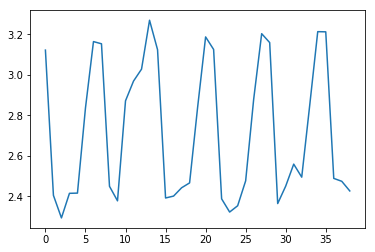

In [26]:
plt.plot(testpreds[129])

In [27]:
preddf=pd.DataFrame(testpreds,index= rrvf_data.idx_to_store(range(testpreds.shape[0]))
                    ,columns= rrvf_data.idx_to_date(range(478,478+39)))
preddf=preddf.unstack().reset_index()
preddf.columns=['date','store','transformed_visitors']
preddf['id']=preddf[['store','date']].apply(lambda u: "_".join(u.values),axis=1)
preddf['visitors']=np.expm1(preddf['transformed_visitors'])
preddf=preddf.set_index(preddf['id'])
preddf.shape

(32331, 5)

In [28]:
preddf.head()

date                 store  \
id                                                                  
air_00a91d42b08b08d9_2017-04-23  2017-04-23  air_00a91d42b08b08d9   
air_0164b9927d20bcc3_2017-04-23  2017-04-23  air_0164b9927d20bcc3   
air_0241aa3964b7f861_2017-04-23  2017-04-23  air_0241aa3964b7f861   
air_0328696196e46f18_2017-04-23  2017-04-23  air_0328696196e46f18   
air_034a3d5b40d5b1b1_2017-04-23  2017-04-23  air_034a3d5b40d5b1b1   

                                 transformed_visitors  \
id                                                      
air_00a91d42b08b08d9_2017-04-23              1.893306   
air_0164b9927d20bcc3_2017-04-23              1.460716   
air_0241aa3964b7f861_2017-04-23              2.373592   
air_0328696196e46f18_2017-04-23              2.166161   
air_034a3d5b40d5b1b1_2017-04-23              3.488959   

                                                              id   visitors  
id                                                                           
air_00a91d42b08b08d9_2017-04-23  air_00a91d42b08b08d9_2017-04-23   5.641289  
air_0164b9927d20bcc3_2017-04-23  air_0164b9927d20bcc3_2017-04-23   3.309046  
air_0241aa3964b7f861_2017-04-23  air_0241aa3964b7f861_2017-04-23   9.735890  
air_0328696196e46f18_2017-04-23  air_0328696196e46f18_2017-04-23   7.724726  
air_034a3d5b40d5b1b1_2017-04-23  air_034a3d5b40d5b1b1_2017-04-23  31.751849

In [29]:
sample=pd.read_csv("../input/sample_submission.csv")
sample.shape

(32019, 2)

In [30]:
submission=preddf[['visitors']].loc[sample['id']]
submission.shape

(32019, 1)

In [31]:
submission.to_csv("../submission/l3_3001_lgb_fold{}_{}_d{}.csv.gz".format(j, EXCLUDE_HARD, PRED_DATE)
                  ,compression='gzip')